# Song lyrics analysis with text mining and songs recommendation

This notebook is split in two parts, at the beginning I analyze the song lyrics and the genres using some text mining techniques in order to explore the data.

In the last section of the notebook I built a simple songs recommendation system that returns the most similar songs related to a given one. I used an evaluation dataset in order to evaluate numerically the suggestions of the system and I computed the mAP on these songs.

First of all I need to download and import the needed libraries.

In [1]:
# Install and import the needed libraries
install.packages("lsa", quiet=T)
install.packages("tm", quiet=T)
install.packages("googledrive", quiet=T)

library("tm")
library("lsa")
library("googledrive")

also installing the dependency ‘SnowballC’


also installing the dependencies ‘NLP’, ‘Rcpp’, ‘slam’, ‘BH’


Loading required package: NLP

Loading required package: SnowballC



## Download the files and load the data

I download the dataset from Drive and it will be loaded to a dataframe in order to use the songs for our analysis. If you want to check the preprocessing applied on the original data you can check the following python script TODO: AGGIUNGERE LINK ALLO SCRIPT SU DRIVE.

In [ ]:
# Download the file from Drive
url_dataset <- "https://drive.google.com/file/d/1-0JneDawEUakvEvlEqw1lFhy1OScRiOr/view?usp=share_link"
url_evaluation <- "https://drive.google.com/file/d/1535h0t9xngWndBfdgEb8QqkFn0L-ZeBL/view?usp=share_link"

drive_deauth()
dl_data <- drive_download(as_id(url_dataset), overwrite=TRUE)
dl_eval <- drive_download(as_id(url_evaluation), overwrite=TRUE)

In [3]:
cat("Loading the dataset csv into a dataframe...")
songs_df <- read.csv(dl_data$local_path)
cat("\nThe dataframe is ready!")

Loading the dataset csv into a dataframe...
The dataframe is ready!

As you can see in the following cell, the dataset has 5 columns, the track id, the title, the artist name, the stemmed lyrics (in BOW version) and the tag (genre) for each song.

In [ ]:
head(songs_df, n=2)

,track_id,title,artist_name,lyrics,tag
,<chr>,<chr>,<chr>,<chr>,<chr>
1,TRAAABD128F429CF47,Soul Deep,The Box Tops,i i i i i i i i i i you you you you you you you you you you you you you you you you you to to to to to to to to and and a a me it it it not not in in in my my my my is is is your your your your your your your that that that that that do do do do do are are are are are are for for for for no have have have have have have so so know know know know know but but but what what what when when time time time can there there there there there la la la la la la la get get got got got never never feel feel want want would would day day day day away away yeah yeah yeah yeah heart heart heart heart heart could could need need need our our look look where where thing thing think live onli onli tri keep keep keep dream dream wanna wanna wanna find find find hear believ everyth everyth someth someth someth someth insid insid chang chang soul soul soul soul soul soul soul new start start pleas pleas true while while deep deep deep deep beat after after fade fade wast wast wast trust alreadi alreadi style style asleep wors wors goal goal,60s
2,TRAAAED128E0783FAB,It's About Time,Jamie Cullum,i i i i i i i i i i i i i i i i i i i i i i i i i i i i the the the the the the the the the the the the the the the you you to to to to to to to to to to to to and and and and and and and and and and and and and and and and and and and and and and a a me me it it it it not not in my my my my my my my my my my my my my my my my my my my my is is is of that that that that that that that do do on are are am am am am am am am am will will will will will will will will will will will will will for for for for for for be be be be have have have love love love love love love love love love love love so so so so so so so so so this this this this but just when when when like time time time time time time come come come come go one one one one out out down if if got got got got got got got from feel feel make make make make make make make make make make way way way way way way way way way take take take take take day day day by her her her her her her heart heart heart could look look look where more more more more more more more been been who who who who through through through through through through onli onli onli tri tri tri tri tri whi dream dream dream well an an an an an an long girl girl girl find find find find find find find find good about about about about about about some some some some some some some some littl wait run walk walk gone someth befor much much much much much much anoth new tonight tonight tonight burn thought realli hard care put seem mine mine mine mine fire someon someon someon someon while doe smile open open open open open open door door door door door door door mayb mayb mayb may may sometim lone lone lone chanc chanc chanc air water readi readi readi readi past happen pretti differ faith search flame piec cos cos cos meant higher edg surpris person twice noon thin celebr celebr celebr inspir advic ideal,jazz


In [ ]:
cat("The dataset contains", nrow(songs_df), "songs.")

The dataset contains 153261 songs.

At this point you can import from Drive also the term-document matrix computed on the 'lyrics' feature to avoid re-running again the code.

In [ ]:
#@title #### Download the term-document table from Drive
#@markdown To avoid running the cell for creating the term-document matrix you can
#@markdown import the pre-saved table and load it in the variable 'tdm'.

library("data.table")

# Download the terms documents table from Drive
url_tdtable <- "https://drive.google.com/file/d/1IZFxCFTUmCljaFY2BerEQNYfsCo1Fn4u/view?usp=share_link"
drive_deauth()
dl_table <- drive_download(as_id(url_tdtable), overwrite=TRUE)

# Load of the terms docs matrix 
cat("Loading the term-document matrix ...\n")
tdm <- as.matrix(fread(file=dl_table$local_path, header=FALSE))

# Extract list of words and set as rownames
words <- strsplit(tdm[, 1], " ")
rownames(tdm) <- words 

# Delete the column with the words and set colnames
tdm <- tdm[, -1]
colnames(tdm) <- 1:ncol(tdm)

# Convert the values to numbers, because importing from table they are characters
class(tdm) <- "numeric"

cat("\nIn the table there are", length(words), "words and", ncol(tdm), "songs.")

Otherwise you can execute the next cells in order to compute the term-document matrix from scratch.

### Create the term-document matrix

In [ ]:
# Save in the vector the lyrics of each song
song_lyrics = songs_df$lyrics

In the next cell the following steps will be executed:
1. load the lyrics in a Corpus object;
2. remove the english stop words;
3. create a term-document matrix;
4. eliminate the sparse terms from the matrix;
5. convert to a matrix R object.

You don't need to remove the punctuation or to make the test lowercase because the lyrics are already normalized in this way.

In [ ]:
# This creates the corpus dataset  
cat("- Creating the corpus dataset ...")
corpus <- Corpus(VectorSource(song_lyrics))

# With tm_map() we normalize our text set, firstly tolower case
#corpus <- tm_map( corpus, tolower ) 
# Then we remove the puntuactions 
#corpus <- tm_map( corpus, removePunctuation ) 

# Remove the stop words from a stoplist 
cat("\n- Removing the stop words ...")
corpus <- tm_map(corpus, removeWords, c(stopwords("english")))

# Now we can create the term-dcoument matrix
cat("\n- Creating the term-document matrix ...")
tdmc <- TermDocumentMatrix(corpus)

# Let's inspect the matrix
inspect(tdmc)

# We eliminate the terms with a frequency in documents lower than 2% 
cat("\n- Removing terms with a low frequency ...")
tdms <- removeSparseTerms(tdmc, 0.98) 
# Note: in LSA it is required that each term appears at least in 2 documents 
# after the elimination the terms are less than before, so we save the actually used words  
words <- rownames(tdms) 

inspect(tdms)

# To use the next functions we need to convert the sparse tdms to a standard R matrix  
cat("\n- Convert to a matrix ...")
tdm <- as.matrix(tdms)

In [ ]:
cat("The term-document matrix has the following dimensions:", nrow(tdm), "x", ncol(tdm))

The term-document matrix has the following dimensions: 511 x 153261

In [ ]:
# Write the term-document matrix in a table to read in some next runs
write.table(tdm, file="tdm.table", append=FALSE, row.names=TRUE, col.names=TRUE)

## Compute LSA on the TF-IDF matrix and visually analyze the data

In [5]:
# Application of the term weighting TF-IDF to the terms-docs matrix
tdmle <- lw_logtf(tdm) * (1-entropy(tdm))  
head(tdmle)

,1,2,3,4,5,6,7,8,9,10,⋯,153252,153253,153254,153255,153256,153257,153258,153259,153260,153261
away,0.19153108,0.0000000,0.00000000,0.280588,0,0.0000000,0.00000000,0.2416853,0.1208427,0,⋯,0.1208427,0.0000000,0.0000000,0.0000000,0.00000000,0,0.00000000,0,0.2416853,0.0000000
beat,0.20538516,0.0000000,0.00000000,0.000000,0,0.0000000,0.00000000,0.0000000,0.0000000,0,⋯,0.0000000,0.0000000,0.2053852,0.0000000,0.00000000,0,0.00000000,0,0.0000000,0.0000000
believ,0.16211522,0.0000000,0.00000000,0.000000,0,0.0000000,0.00000000,0.0000000,0.0000000,0,⋯,0.0000000,0.1621152,0.0000000,0.0000000,0.00000000,0,0.00000000,0,0.0000000,0.0000000
can,0.09046905,0.0000000,0.09046905,0.000000,0,0.1809381,0.09046905,0.0000000,0.0000000,0,⋯,0.0000000,0.1809381,0.0000000,0.0000000,0.09046905,0,0.09046905,0,0.0000000,0.0000000
chang,0.25697080,0.0000000,0.00000000,0.000000,0,0.0000000,0.00000000,0.0000000,0.0000000,0,⋯,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0,0.00000000,0,0.0000000,0.0000000
day,0.25875722,0.2228813,0.00000000,0.000000,0,0.0000000,0.00000000,0.0000000,0.0000000,0,⋯,0.0000000,0.0000000,0.0000000,0.1114407,0.00000000,0,0.00000000,0,0.0000000,0.1766293


In [ ]:
# With this function we compute the norm of a vector
norm_vec <- function(x) sqrt(sum(x^2))

# We can compute the norm of each term in the terms-docs matrix
norm_terms <- apply(tdmle, 1, norm_vec)

# LSA space creation with rank automatically choosen by R
lsar <- lsa(tdmle) 

cat("The number of computed eigenvalues is", length(lsar$sk))

The number of computed eigenvalues is 209

You can see from the following chart that the difference in magnitude between the first eigenvalues is larger than the distances starting from the fifth onwards.

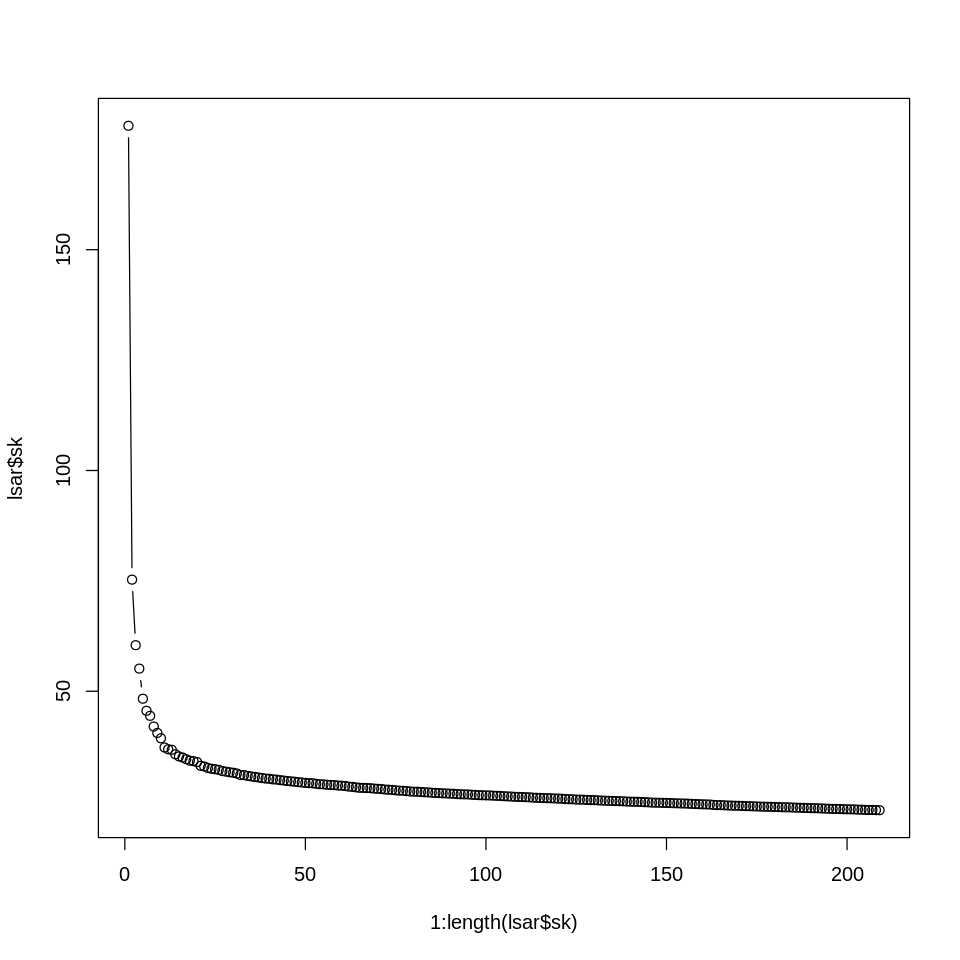

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
plot(1:length(lsar$sk), lsar$sk, type="b")

All operations performed in the latent semantic space have to consider the different relevance of each column, therefore I computed the terms and the documents matrices re-weighting by the eigenvalues.

In [ ]:
# Let's compute the two matrices of terms and docs, weighted by the eigenvalues
tls <- lsar$tk %*% diag(lsar$sk)
dls <- lsar$dk %*% diag(lsar$sk)

Given that the norm of each term represents the importance of that word in the latent space, I computed the norms of all terms and I added it as a column to the terms matrix. In this way I will be able to use this information in some future operations.

In [ ]:
# Compute the norm for each term
norm_terms_lsa <- apply(tls, 1, norm_vec)

# Add the column of the norms to the matrix tls
tls_norm_terms = cbind(tls, norm_terms_lsa)

We can explore the top words in terms of norm and you can see that among the most relevant, there are some words in a language different from english, that's because we have a lot of english songs and few songs of other countries.

In [ ]:
cat("The norm of the word 'pour' is", norm_terms_lsa['pour'])
cat("\nThe norm of the word 'que' is", norm_terms_lsa['que'])

The norm of the word 'pour' is 20.55518
The norm of the word 'que' is 51.9999

In [ ]:
sorted_norms <- sort(norm_terms_lsa, decreasing=T)
cat("The terms with the highest norm are:\n")
cat(paste(names(sorted_norms[1:15]), unname(sorted_norms[1:15]), sep=':', collapse="\n"))

The terms with the highest norm are:
que:51.9998982860653
love:46.2663193309754
babi:44.7223310771761
yeah:43.5667546356448
get:39.6857875632179
wanna:39.1483136874664
got:38.9084218519568
gonna:38.853463507302
und:38.572898848387
hey:38.2582182411634
let:38.025055601226
want:37.7731156964258
girl:37.5472447932084
come:36.372243290141
like:35.7944283761901

As seen before, the first eigenvalues are the ones with the highest values, let's try to plot the words considering the first two latent dimensions. 

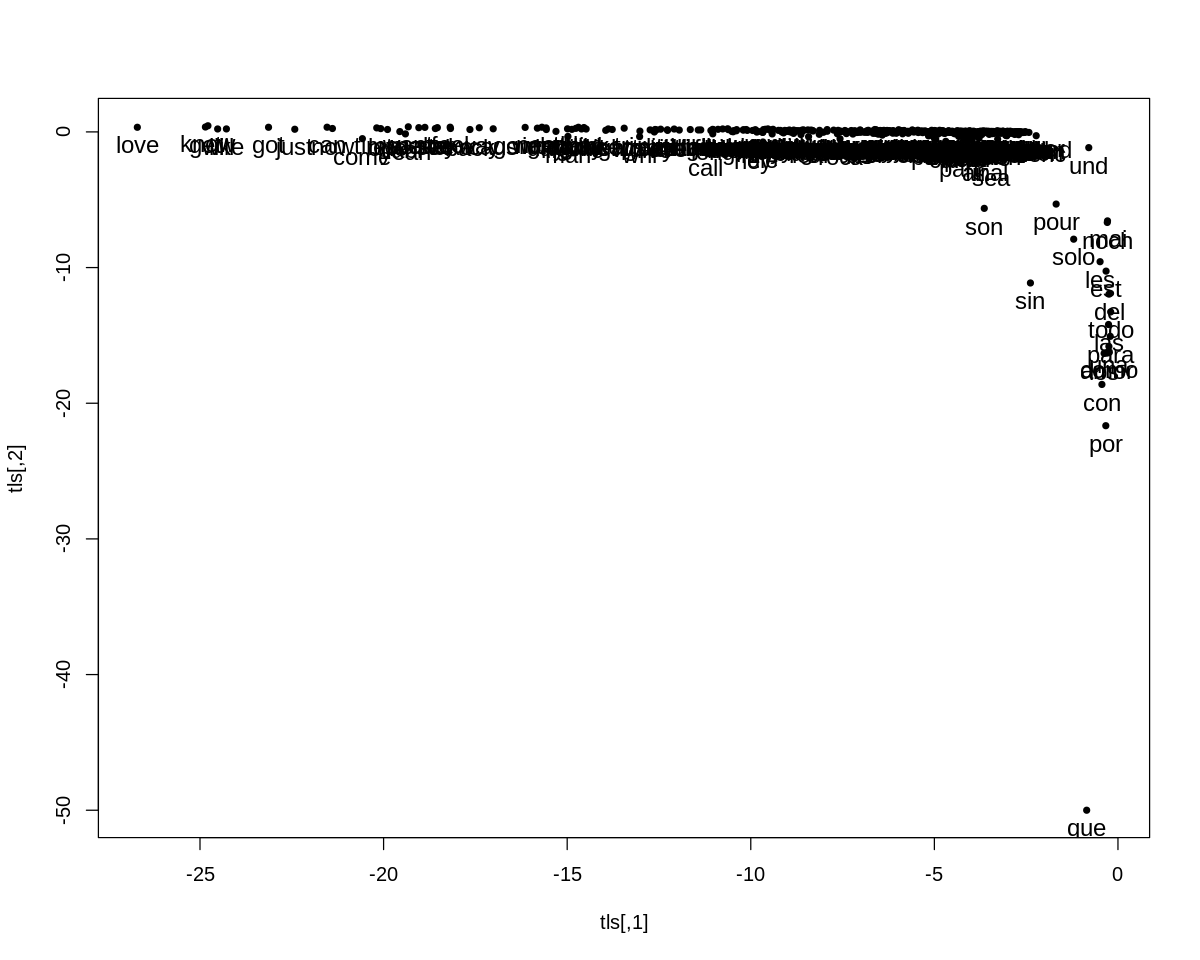

In [ ]:
# Graphic representation of terms using the first two latent dimensions
options(repr.plot.width=10, repr.plot.height=8)
plot(tls, pch=20)
text(tls, labels=words, cex=1.2, pos=1)

We have a lot of words close to the origin, thus they don't contain relevant information. The first latent dimension, with the corresponding eigenvalue, dominates the second dimension, that's why we have a compressed space along one dimension. 

Moreover let's try to remove some terms to have a clearer graph, selecting only the terms with a norm higher than a given threshold.

In [ ]:
# We added one column at the end so we take length + 1
last_col <- length(lsar$sk)+1

# Computing the mean of the norm for the terms in order to set a suitable threshold
cat("The mean for the norm of the terms is", mean(tls_norm_terms[,last_col]))

The mean for the norm of the terms is 17.03436

In [ ]:
# Subset of terms with norm > 18 (the last column contains the norms)
tls_reduced <- subset(tls_norm_terms, norm_terms_lsa > 18.0)[,-last_col]

cat("After the reduction we have", nrow(tls_reduced), "words.")

After the reduction we have 226 words.

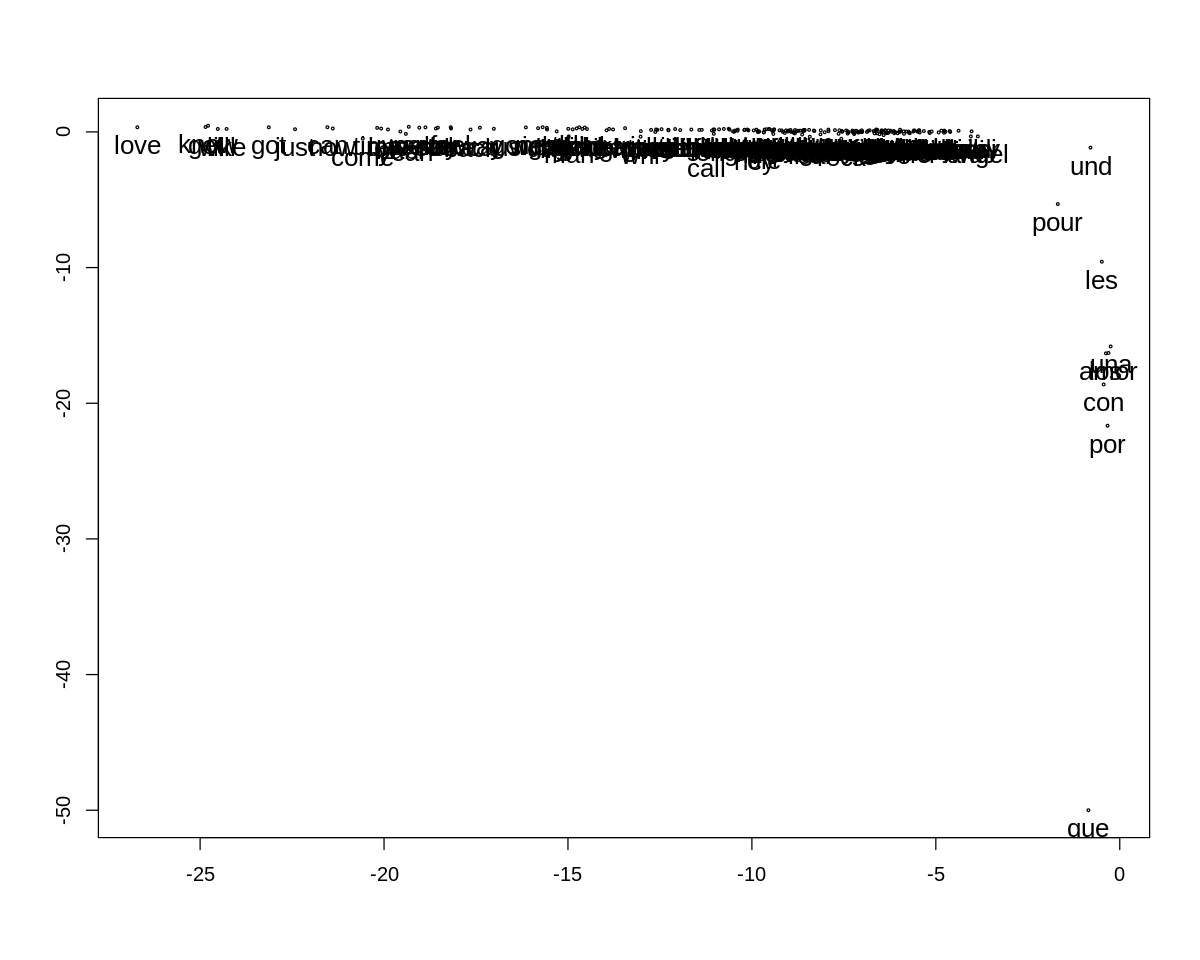

In [ ]:
# Representation of this terms subset using the first two latent dimensions
options(repr.plot.width=10, repr.plot.height=8)
plot(tls_reduced, pch=21, cex=0.3)
# Change the rownames otherwise mislabeled
text(tls_reduced, labels=rownames(tls_reduced), cex=1.3, pos=1)

I also plot the documents to check the distribution of them and it's similar to the one of the terms. 

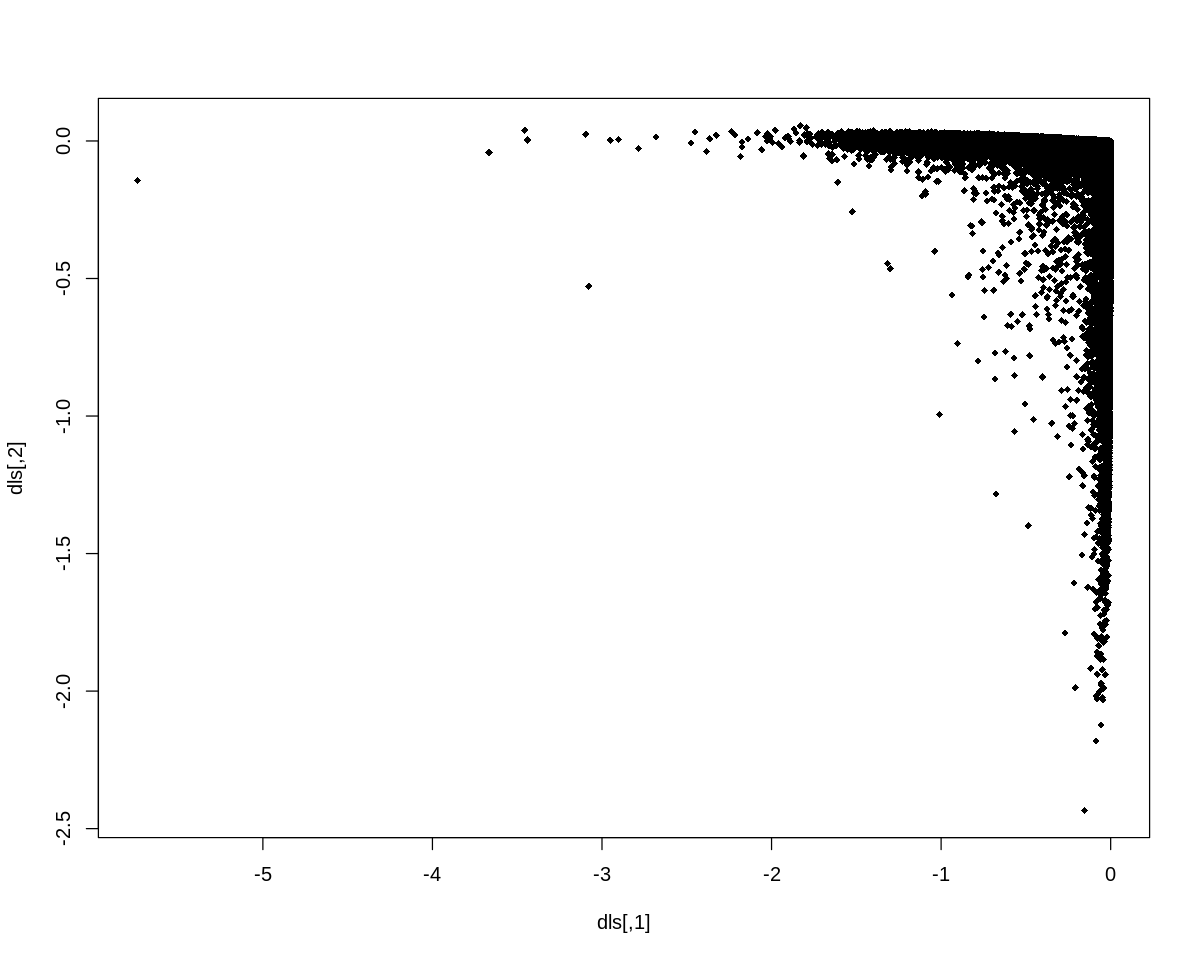

In [ ]:
# Graph of the documents using the first two latent dimensions
plot(dls, pch=18, cex=0.8)

We have the same problem, the documents are compressed in a narrow space and the majority of data is following a specific direction and it's within an area. We need that documents and words are as distributed as possible, radially from the origin. In cosine similarity, this alignment means that we are finding correlations and the elements are correlated with each other.

Let's try to display the elements with the second and third latent dimensions, the distance between these 2 eigenvalues is lower than the one between the first and the second eigenvalues.

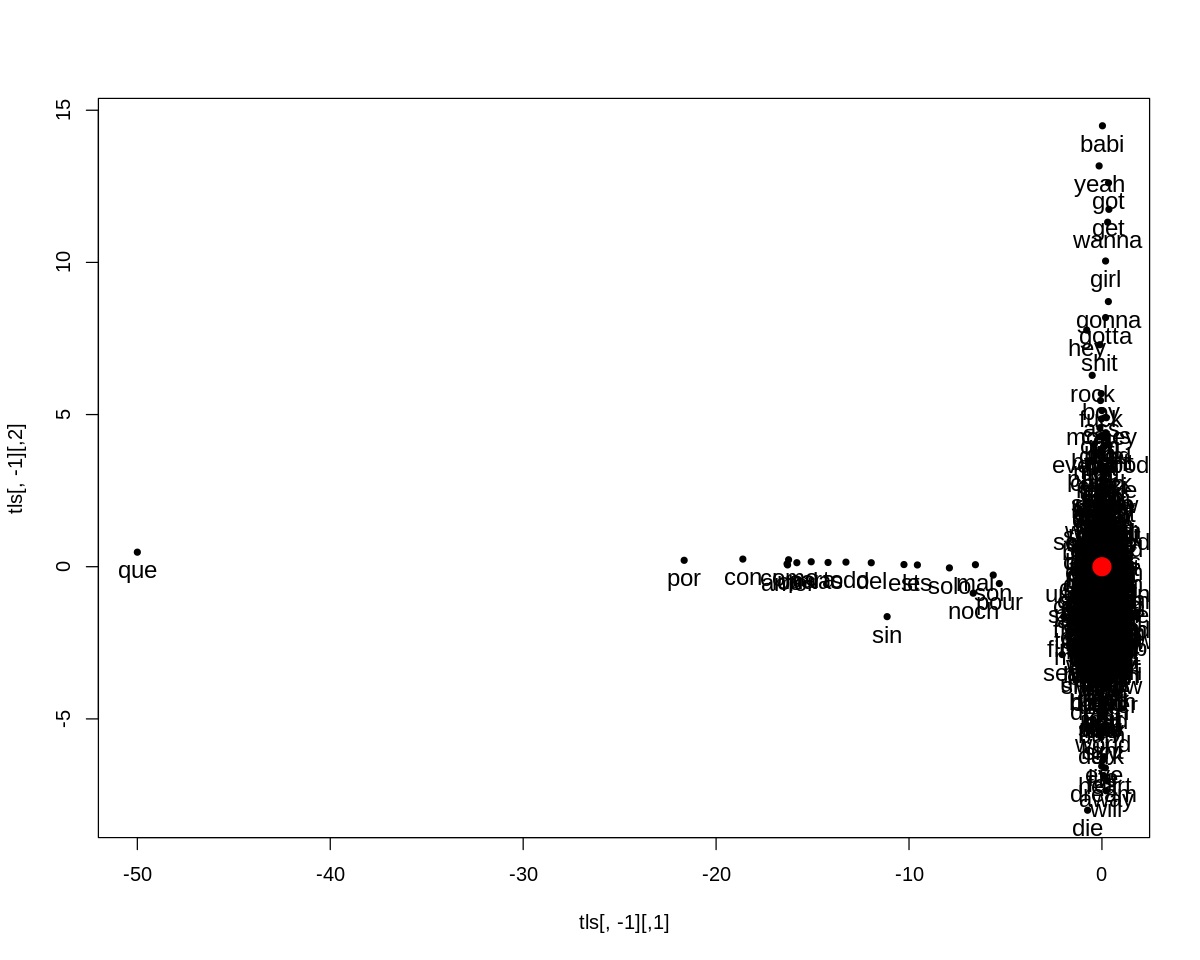

In [ ]:
# Graph representation of the terms using the second and third latent variables
options(repr.plot.width=10, repr.plot.height=8)

# -1 removes the first latent dimensions in order to display 2° and 3°
plot(tls[,-1], pch=20) 
text(tls[,-1], labels=words, cex=1.2, pos=1)

# Draw the origin 0,0 of the cartesian plane
points(0, 0, pch=20, cex=3, col="red")

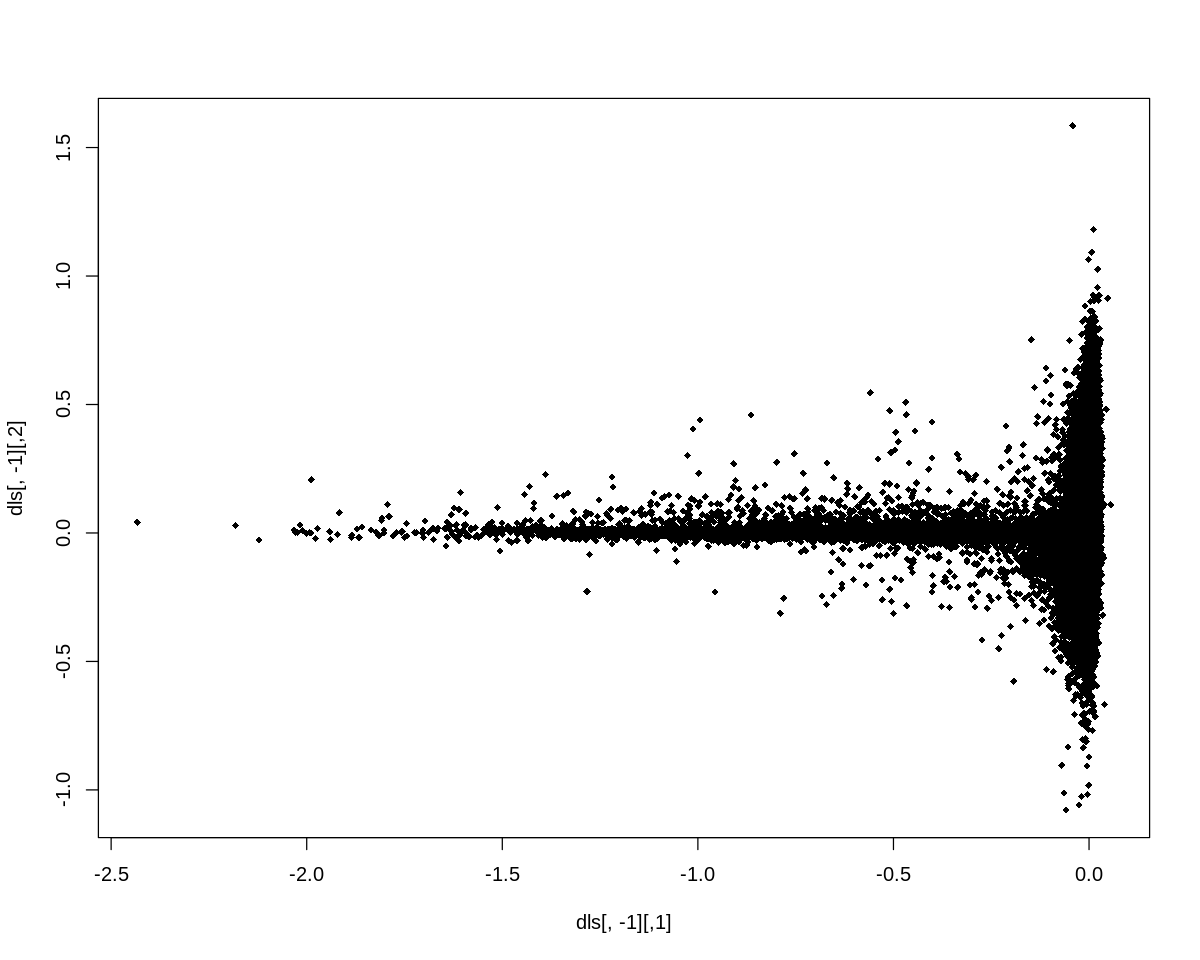

In [ ]:
# Graph of docs using 2° and 3° latent dimensions
plot(dls[,-1], pch=18, cex=0.8)

Now the words and documents are more distributed in several directions, because the values of the considered eigenvalues are more similar and therefore neither dimension compresses the other.

Let's try to plot also the third and fourth latent dimensions to confirm the previous idea.

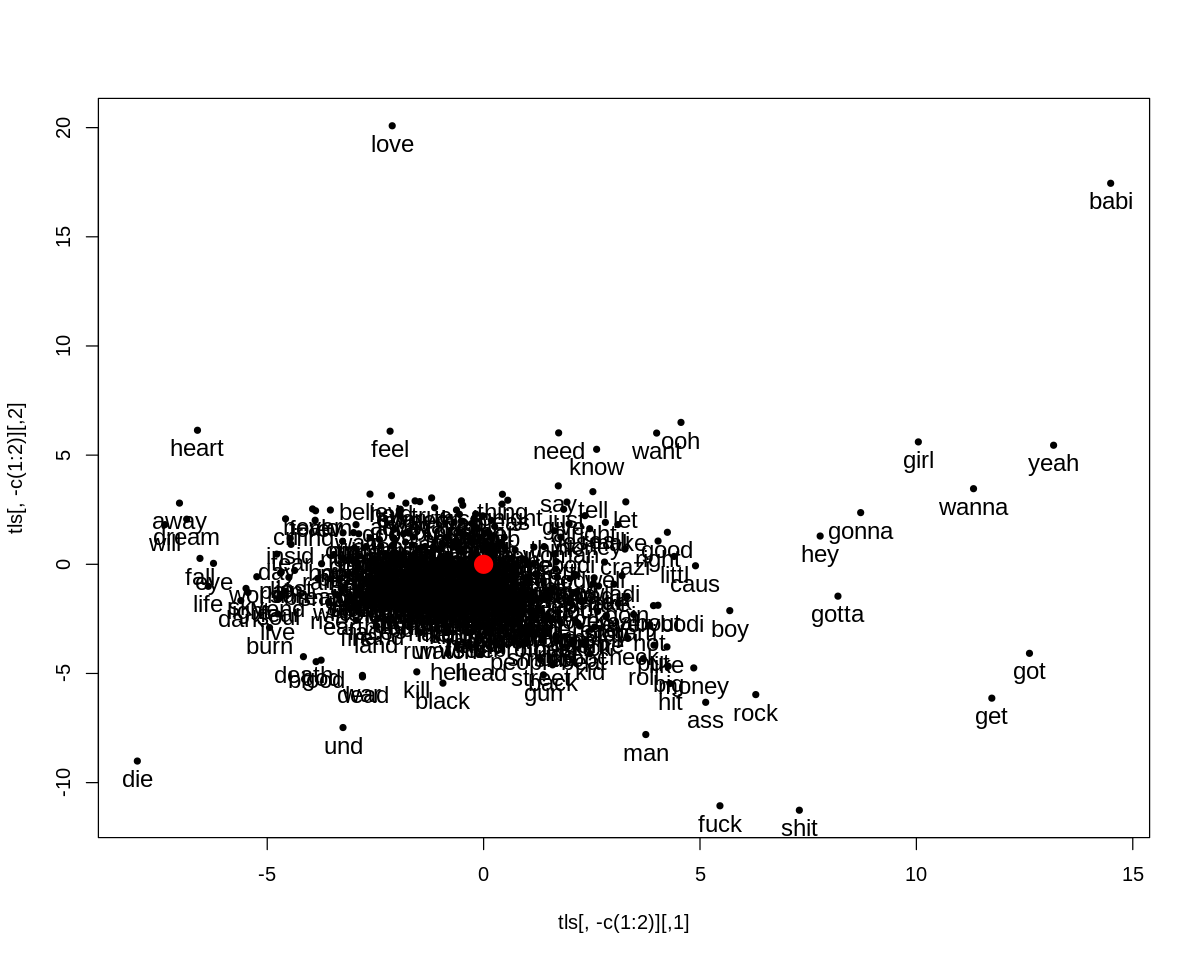

In [ ]:
# Graph representation of the terms using the third and fourth latent variables
options(repr.plot.width=10, repr.plot.height=8)

# -c(1:2) removes the first latent dimensions in order to display 3° and 4°
plot(tls[,-c(1:2)], pch=20) 
text(tls[,-c(1:2)], labels=words, cex=1.2, pos=1)

# Draw the origin 0,0 of the cartesian plane
points(0, 0, pch=20, cex=3, col="red")

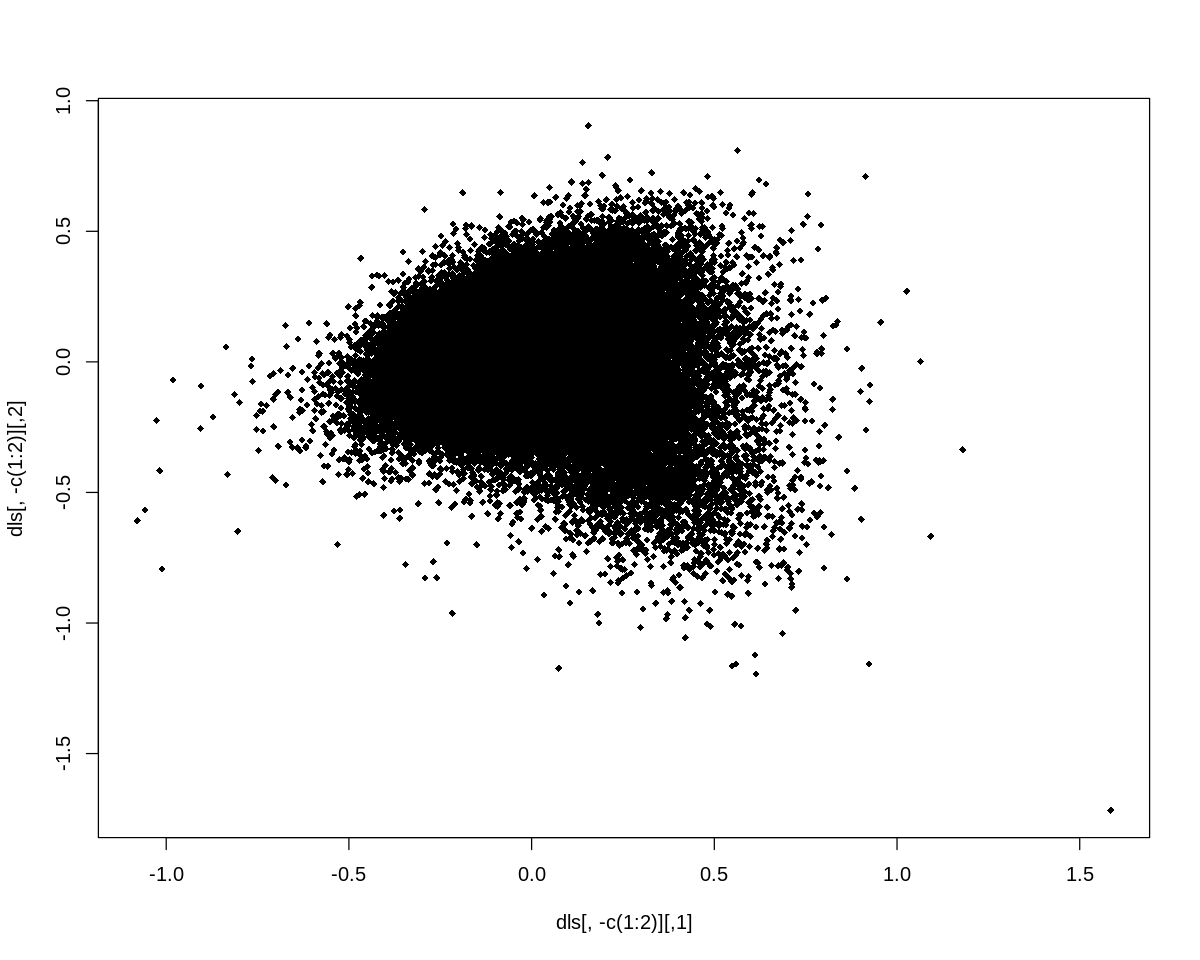

In [ ]:
# Graph of docs using 2° and 3° latent dimensions
plot(dls[,-c(1:2)], pch=18, cex=0.8)

As you can see, the elements are now distributed almost in a circle, therefore I will consider these dimensions in the following tests.

## Analysis of song genres

In [4]:
install.packages('dplyr', quiet=T)
library('dplyr')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Let's print the most represented genres and check how many elements we have for the first 10 genres.

In [ ]:
genres <- songs_df$tag

genre_10 <- summary(as.factor(genres))[1:10]
cat(paste(names(genre_10), genre_10, sep=":", collapse='\n'))

rock:13475
pop:5792
indie:5524
country:4043
punk:3538
soul:2493
folk:2473
80s:2203
classic rock:2047
alternative:1949

In [ ]:
cat("The", genre_10['rock']*100/length(genres),"% of songs are rock.")

The 8.792191 % of songs are rock.

The total number of genres is very high but for the purpose of the project, I restricted them to the top 10 and I created a color mapping for these ones in order to make a plot.

In [ ]:
# Take only the songs that are among the top 10 genres
top_genre_rows <- genres %in% names(genre_10)

# Creates color mapping to plot the genres
color_mapping <- recode(genres, rock="red", pop="blue", indie="green", country="burlywood4",
                        punk="blueviolet", soul="aquamarine", folk="deeppink", "80s"="chartreuse",
                        "classic rock"="darkgoldenrod1", alternative="deepskyblue", .default='black')

In the following cell I keep only the elements from the genre list that belong to one of the top 10 music styles.

In [ ]:
# Conversion of the class names to colors in order to distinguish in the graph the genre of the songs.
genre_colors = as.vector(color_mapping)[top_genre_rows]

head(genre_colors[1:10])
head(genres[top_genre_rows][1:10])

[1] "chartreuse"     "darkgoldenrod1" "green"          "green"         
[5] "green"          "red"

[1] "80s"          "classic rock" "indie"        "indie"        "indie"       
[6] "rock"

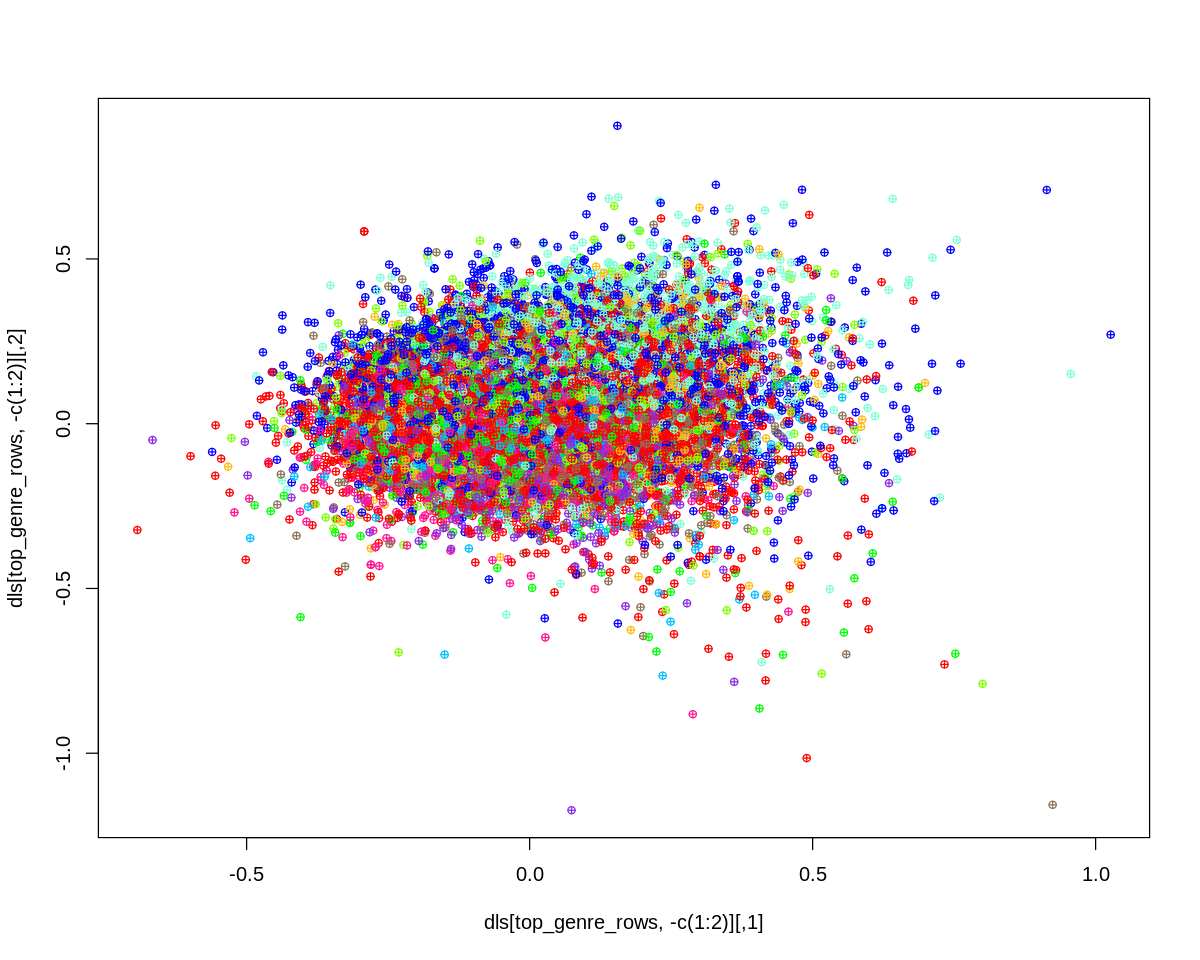

In [ ]:
# Let's plot only the top genres to better understand the distribution removing noise
options(repr.plot.width=10, repr.plot.height=8)
plot(dls[top_genre_rows, -c(1:2)], pch=10, cex=0.8, col=genre_colors)

We cannot deduct a lot of information from the graph, probably because in songs of different genres the artists can still use similar words and only change the melody. Moreover, we have a lot of rock and pop songs, therefore it's more likely to find a lot of different words for those genres than for the others. 

Let's try to restrict the analysis to four genres that can be considered quite interesting, soul songs are different from classic rock ones and classic rock songs may have some similarities with country music. Alternative is basically different from others but with some common points.

In [ ]:
# Take some different genres
genre_4_rows <- genres %in% c('soul', 'country', 'classic rock', 'alternative')

genre_4_colors = as.vector(color_mapping)[genre_4_rows]

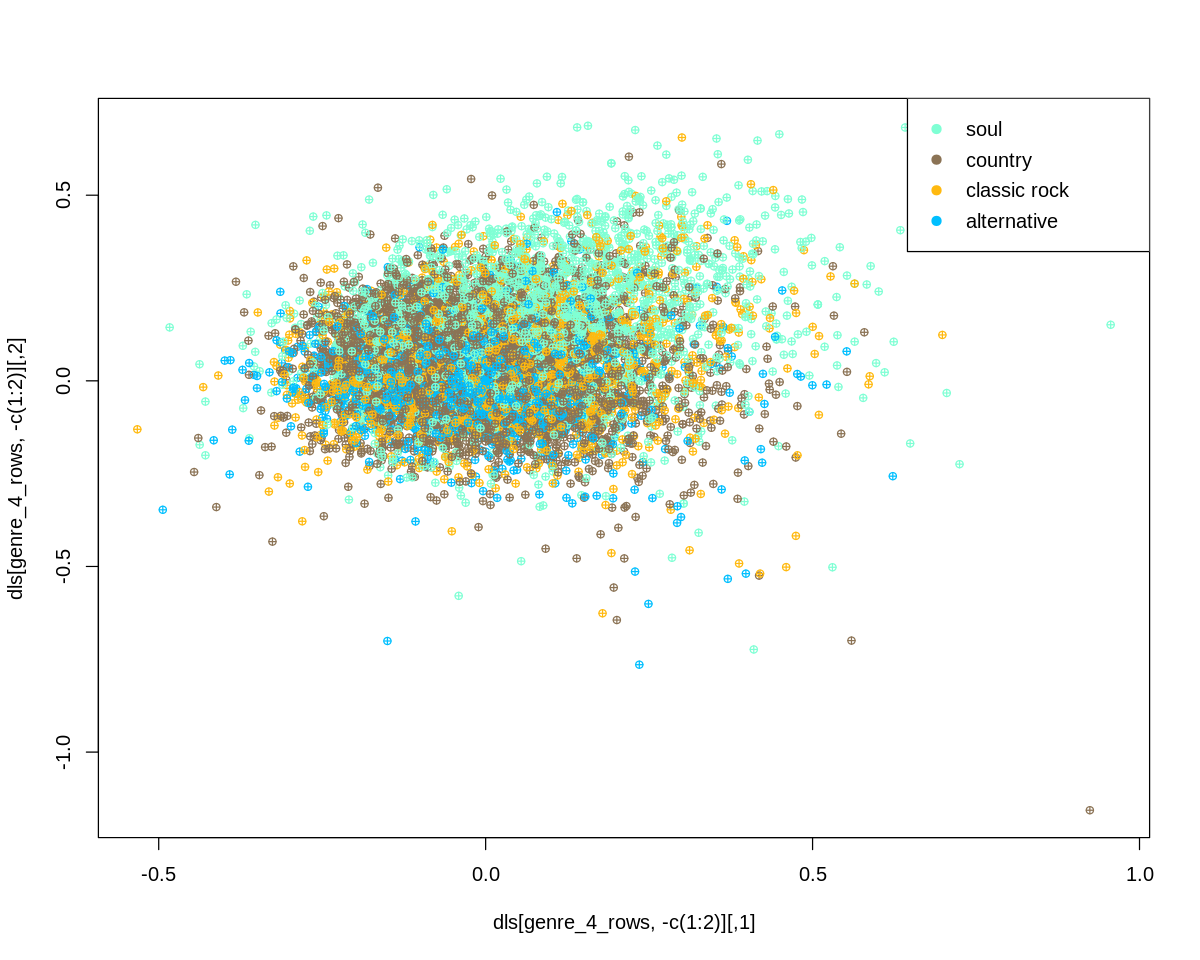

In [ ]:
# Let's plot only some genres to better understand the distribution
options(repr.plot.width=10, repr.plot.height=8)
plot(dls[genre_4_rows, -c(1:2)], pch=10, cex=0.8, col=genre_4_colors)
legend(x="topright", legend=c("soul", "country", "classic rock", 'alternative'), col=c("aquamarine", "burlywood4", "darkgoldenrod1","deepskyblue"), pch=19) 

As you can see the soul is quite expanded at the top of the graph, while classic rock and country, that are related genres, are more compacted. 

In [ ]:
# Retrieve only top 135 words, considering the norm, to avoid confusion in the graph
top_terms <- names(sort(norm_terms_lsa, decreasing=T)[1:135])
top_terms_rows <- rownames(tls) %in% top_terms

In [ ]:
# Definition and application of the function for the normalization of terms and docs vectors 
# indeed the vectors tls and dls are not normal because achieved by the product with sk
norm_rows <- function(x) x / apply(x, 1, norm, "2")
tlsn <- norm_rows(tls)
dlsn <- norm_rows(dls)

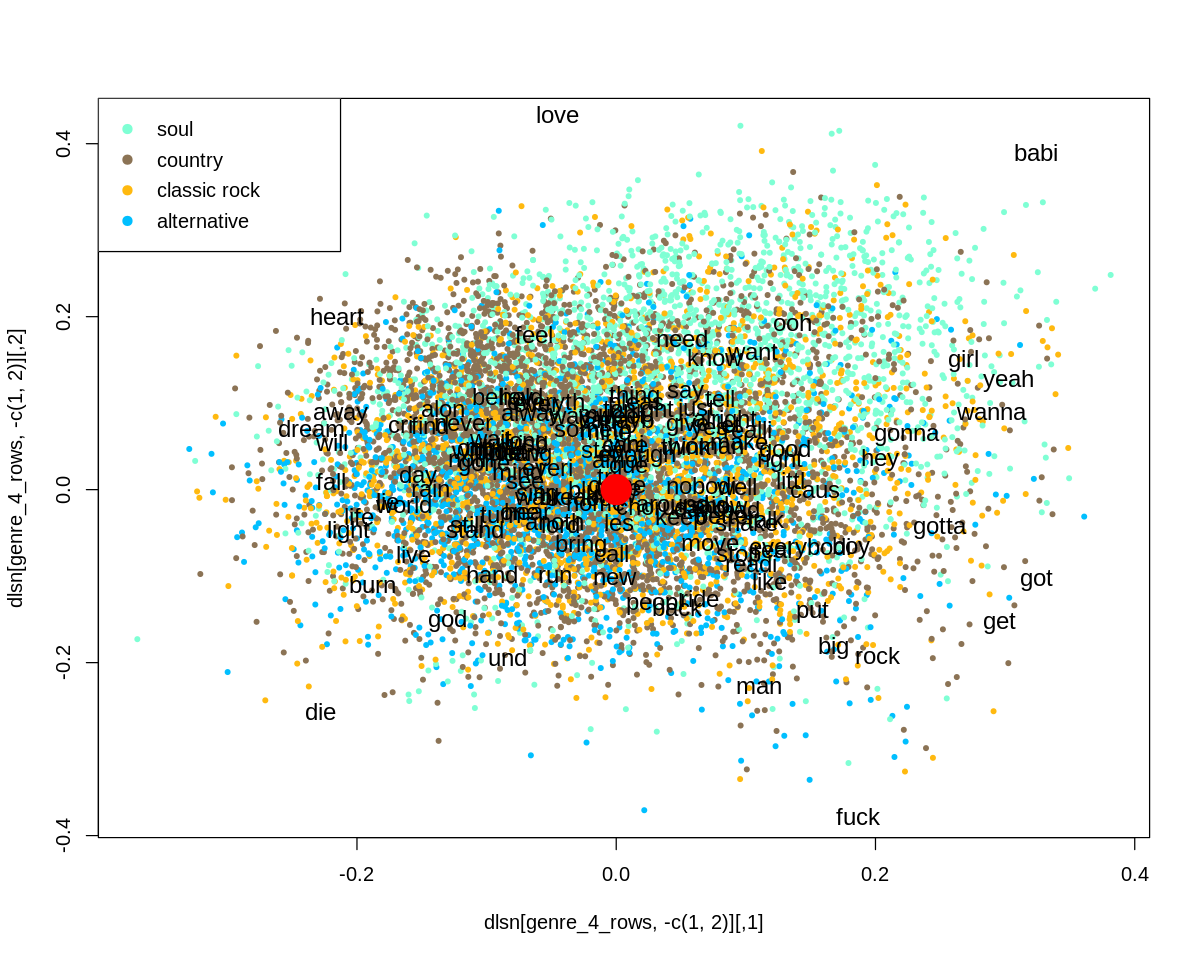

In [ ]:
# New graph with normalized vectors of terms and docs
options(repr.plot.width=10, repr.plot.height=8)
plot(dlsn[genre_4_rows,-c(1,2)], pch=20, cex=0.8, col=genre_4_colors)
text(tlsn[top_terms_rows,-c(1,2)], labels=words[top_terms_rows], cex=1.2)
points(0, 0, pch=20, cex=5, col="red")
legend(x="topleft", legend=c("soul", "country", "classic rock", 'alternative'), col=c("aquamarine", "burlywood4", "darkgoldenrod1","deepskyblue"), pch=19) 

If you have the document and word embeddings and you want to represent them in 2 dimensions, you have "to cut" the vectors but there is no guarantee to capture most of relevant information, you are simply looking at a specific projection (keeping the first 2 dimensions for example). The distribution that you show may be wrong with respect to the real distribution. 

Using the LSA approach, you are sure that the first dimensions capture much more information than the others, therefore the problem is less relevant.

At this point, I want to check if there is a correlation between a characteristic word of 'country' with songs of this genre.

## Chi-square tests to observe correlation between some words and some genres

I decided to test the term 'heart', it is far from the other words in the graph and close to some 'country' songs. Let's verify objectively if exits a lexical correlation between the term and some genres in the original space tdm, i.e. not-lsa.

In this case, I consider only the docs containing the term and I do the analysis using the chi-square test.

In [ ]:
# We compute the contingency matrix
heart_co <- table(tdm["heart",] > 0, genres=="country")

dimnames(heart_co) <- list(heart=c("No", "Yes"), "country"=c("No", "Yes"))
# This function computes automatically the expected frequencies (i.e. theoretical) 
# from the observed ones. We don't need to correct because we don't have small values.
chisq_test_co = chisq.test(heart_co, correct=FALSE) 

# chi-square distribution is simply the summation of several squared variables and
# they are normally distributed (this is the theoretical squared distribution).
chisq_test_co


	Pearson's Chi-squared test

data:  heart_co
X-squared = 573.96, df = 1, p-value < 2.2e-16


In [ ]:
# Expected values and observed values from the chisquare test 
chisq_test_co$expected
chisq_test_co$observed

,No,Yes
No,122449.29,3317.7128
Yes,26768.71,725.2872


     country
heart     No    Yes
  No  123026   2741
  Yes  26192   1302

As you can see, the term is very correlated to the genre considering the original matrix. Just from the deviation between the expected and the observed values for "Yes"-"Yes" you may expect a high chi-square and a small p-value. 

To show another example, the p-value for the term 'heart', considering the 'classic rock' genre is very high.

In [ ]:
# We compute the contingency matrix
heart_cr <- table(tdm["heart",] > 0, genres=="classic rock")

dimnames(heart_cr) <- list(heart=c("No", "Yes"), "classic rock"=c("No", "Yes"))

chisq_test_cr = chisq.test(heart_cr, correct=FALSE) 
chisq_test_cr


	Pearson's Chi-squared test

data:  heart_cr
X-squared = 0.1547, df = 1, p-value = 0.6941



In order to refine the query and to get a more precise hint about the correlation between the term and the genre, I first check which are the most similar terms to 'heart' and then I perform the Chi-squared test again.

### Expand the query with semantically related terms

As said in the previous cell, I cannot conclude that a relation exists between the term and the genre simply considering that test. Therefore, I will add a semantically similar term to the query in order to have a better intuition about the relationship. 

In [ ]:
# Find the semantically closest terms to heart in the LSA space
similar5 <- associate(tls[,3:4], "heart", threshold=0.8)[1:5]
cat("The 5 most similar terms to 'heart':\n", names(similar5),"\n",similar5)

# Check the norm
tmp_norm <- sort(norm_terms_lsa, decreasing=T)
cat("\n\nThe value of the norm for:\n", names(similar5))
data.frame(tmp_norm, row.names=names(tmp_norm))[names(similar5),]

The 5 most similar terms to 'heart':
 knew anymor smile long promis 
 0.9999862 0.999268 0.9983046 0.9962172 0.9957185

The value of the norm for:
 knew anymor smile long promis

[1] 11.109105  9.400300 13.817280 29.541468  7.707318

Given that all these 3 words are very similar, but the norms are quite different, I take the term with the highest norm that is 'long'.

In [ ]:
# Let's verify if also the couple "rock like" is objectively correlated to the classic rock genre
heart_long_co <- table(tdm["heart",]>0 & tdm["long",]>0, genres=="country")
dimnames(heart_long_co) <- list("heart long"= c("No", "Yes"), country=c("No", "Yes"))
chisqtest = chisq.test(heart_long_co, correct=FALSE)

chisqtest


	Pearson's Chi-squared test

data:  heart_long_co
X-squared = 266.95, df = 1, p-value < 2.2e-16


The p-value is very low, therefore the query is related to the genre 'country', but I will perform also a semantic analysis in the next cells.

I also want to consider the most similar terms computed on the second and third latent dimensions, in order to check if some different words appear.

In [ ]:
# Find the semantically closest terms to heart in the LSA space
similar5 <- associate(tls[,2:3], "heart", threshold=0.8)[1:5]
cat("The 5 most similar terms to 'heart':\n", names(similar5), "\n", similar5)

# Check the norm
tmp_norm <- sort(norm_terms_lsa, decreasing=T)
cat("\n\nThe value of the norm for:\n", names(similar5))
data.frame(tmp_norm, row.names=names(tmp_norm))[names(similar5),]

The 5 most similar terms to 'heart':
 word clear hide behind insid 
 1 0.9999999 0.9999998 0.9999997 0.9999987

The value of the norm for:
 word clear hide behind insid

[1] 21.510936  5.521859 11.028880 12.445799 24.074188

The most similar term is 'word' and it has a quite high norm, therefore I consider it for performing the Chi-squared test.

In [ ]:
# Let's verify if the couple "heart word" is correlated to the country genre
heart_word_co <- table(tdm["heart",]>0 & tdm["word",]>0, genres=="country")
dimnames(heart_word_co) <- list("heart word"= c("No", "Yes"), "country"=c("No", "Yes"))
chisqtest = chisq.test(heart_word_co, correct=FALSE)

chisqtest


	Pearson's Chi-squared test

data:  heart_word_co
X-squared = 35.98, df = 1, p-value = 1.993e-09


Also in this case the p-value is very low, this means that the query 'heart word' is correlated to the genre 'country'.

### Use LSA to capture semantic meaning

Up to now, I am basing my analysis on lexical matching, let's try to exploit LSA in order to capture semantic meaning. We want to see if there is a semantic correlation between the couple of terms and the genre.

In [ ]:
# To peform this analysis let's transform the query "heart long" in a doc and do the fold_in in the LSA space
heart_long_query <- "heart long"
heart_long_vec <- query(heart_long_query, words)
heart_long_le <- lw_logtf(heart_long_vec) * (1-entropy(tdm))
heart_long_ls <- t(heart_long_le) %*% lsar$tk
heart_long_ls

HEART LONG,-0.01804449,2.196386e-05,-0.01798832,0.01751603,-0.0007394069,0.01162727,-0.000780114,-0.005371723,-0.006015362,-0.008659495,⋯,-0.002544256,-0.002674744,-0.005238946,0.009630401,0.001948346,0.001087361,0.003658304,0.01450893,-0.001799284,-0.004150708


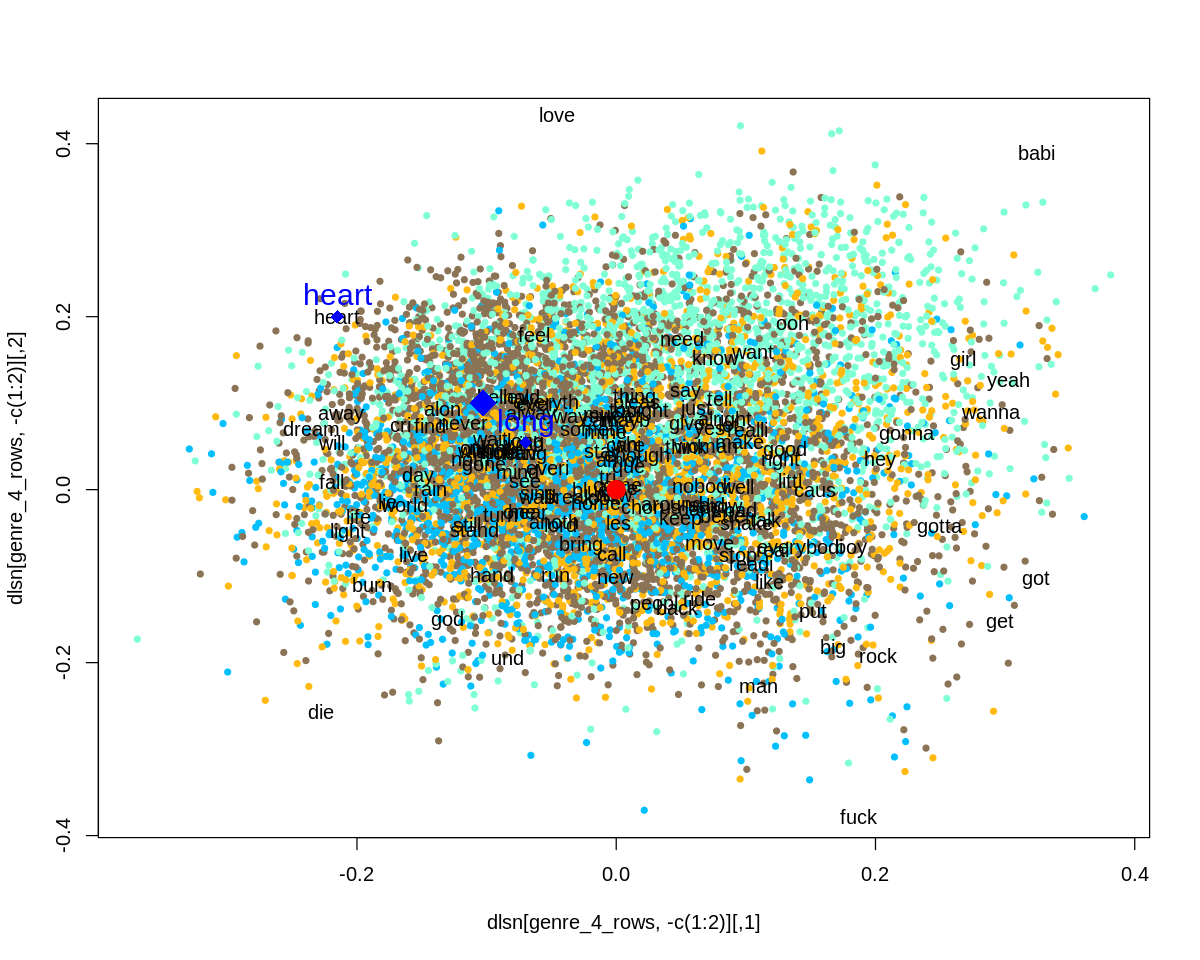

In [ ]:
# Graph of the terms, docs and query in the LSA space using the dimensions 3 and 4
plot(dlsn[genre_4_rows,-c(1:2)], pch=20, cex=1, col=genre_4_colors)
text(tlsn[top_terms_rows,-c(1:2)], labels=words[top_terms_rows], cex=1)
points(0, 0, pch=20, cex=3, col="red") 

heart_long_ls_n <- norm_rows(heart_long_ls)
points(heart_long_ls_n[3], heart_long_ls_n[4], cex=3, pch=18, col="blue")
# Set the text of the 2 terms in order to visualize better
heart_word <- tlsn['heart',]
long_word <- tlsn['long',]

text(heart_word[3], heart_word[4], labels='heart', cex=1.5, col="blue", pos=3)
points(heart_word[3], heart_word[4], cex=1.5, pch=18, col="blue")
text(long_word[3], long_word[4], labels='long', cex=1.5, col="blue", pos=3)
points(long_word[3], long_word[4], cex=1.5, pch=18, col="blue")

In [ ]:
# Define the function that returns a vector of cosine similarities between vector Q and the rows of matrix X
cosines <- function(X, Q) apply(X, 1, cosine, as.vector(Q))

# Function that returns the indices of the N higher values in X 
top <- function(X, N) order(X, decreasing=TRUE)[1:N]

Now I can use these functions to compute the most similar songs to a given input, the query 'heart long' in this case.

In [ ]:
# Top 10 songs that are more semantically similar to the query, considering only 3° and 4° latent dimensions
sim_10_songs <- top(cosines(dls[,3:4], heart_long_ls[3:4]), 10)

# List the 10 songs
songs_df[sim_10_songs, c('title','artist_name', 'tag')]

,title,artist_name,tag
,<chr>,<chr>,<chr>
26030,The Prison's Going Down,Hugh Cornwell,law
68455,Fearless,American Music Club,indie
253,Trusty Chords,Hot Water Music,punk
137760,Counting To Sleep,Wallis Bird,female vocalists
113288,You & Me Song,The Wannadies,pop
32790,Peace Of Mind,DecembeRadio,rock
4599,Drop The Hammer,The Gone Jackals,biker
152495,Lady Solitude,Richard Hawley,singer-songwriter
145143,We Are Loved,David Crowder*Band,electronic


I printed the lyrics for some songs but given that the text is stemmed and in a bag of words format I was not able to do a sensible examination.

In [ ]:
as.list(songs_df[c(26030,26030, 107095), 'lyrics'])

[[1]]
[1] "the the the the the the the to to to and a a a a it it not is is of of that do will will will all all be be love love this but what what what just when when time there there go go go up they they out out down down down down get get was he he he he feel feel as as life think who dream dream his said did hold lie him him without free seem someon those doe wonder lone after wall soon crazi past abov rest veri bed fast futur bout bird wide phone four awak view explain prison prison prison woke afternoon crew realis upset misunderstood"

[[2]]
[1] "the the the the the the the to to to and a a a a it it not is is of of that do will will will all all be be love love this but what what what just when when time there there go go go up they they out out down down down down get get was he he he he feel feel as as life think who dream dream his said did hold lie him him without free seem someon those doe wonder lone after wall soon crazi past abov rest veri bed fast futur bout bird wide phone four awak view explain prison prison prison woke afternoon crew realis upset misunderstood"

[[3]]
[1] "i i i i i the the you you you you you you you you to and a a a a a me me me me me it it it it it it is is is is is is is of of of of your your that that that that that that that do do on on are are we am am no be be be love love love love what what when when see see see see make make make make thing thing thing thing world or or or or or keep dream girl around around light light face hear hear head believ these these these these sing must must must heaven heaven heaven angel angel gave speak met piec piec piec wing wing strength special shoulder rush walkin walkin walkin ordinari halo seein"

As you can see, the majority of similar songs are not actually related to the 'country' genre, but considering the title and trying to understand the lyrics maybe they have something similar to the given query. Moreover, each song can belong to more than one genre, thus this feature is not very reliable in the evaluation of the similarity between 2 songs.

I also tried to perform the search for the second query, "heart word", considering this time the second and third latent dimensions (the dimensions whereby the term 'word' was similar to 'heart').

In [ ]:
heart_word_query <- "heart word"
heart_word_vec <- query(heart_word_query, words)
heart_word_le <- lw_logtf(heart_word_vec) * (1-entropy(tdm))
heart_word_ls <- t(heart_word_le) %*% lsar$tk
heart_word_ls

HEART WORD,-0.01666914,0.0004409315,-0.02028484,0.01196797,0.0006683627,0.0006783379,-0.0006924745,0.006549816,-0.01980355,-0.002736481,⋯,-0.01279946,-0.003221532,0.01619831,0.03382945,-0.01802382,0.02784785,0.004244941,0.01331506,-0.007694231,-0.01903247


In [ ]:
# Top 10 songs that are more semantically similar to the query, considering only 2° and 3° latent dimensions
sim_10_songs_hw <- top(cosines(dls[,2:3], rock_roll_ls[2:3]), 10)

# List the 10 songs
songs_df[sim_10_songs_hw, c('title','artist_name', 'tag')]

,title,artist_name,tag
,<chr>,<chr>,<chr>
86782,Bloody Ballade,MANDRAGORA SCREAM,Gothic Metal
135932,Behind Closed Eyelids,Shpongle,psychedelic
87203,All I Do is Dream of You,Gene Kelly,showtunes
97175,Mechanical spin phenomenon,MNEMIC,metalcore
136238,October Sky,Javier,smooth
142188,Winter Is Blue,Vashti Bunyan,folk
81916,Heaven And Alchemy,Siouxsie,Gothic
45416,The Other Side Of The World,Swans,swans
24409,Look Away,Enchant,Progressive rock


In [ ]:
as.list(songs_df[c(86782, 142188, 24409),'lyrics'])

[[1]]
[1] "i i i i i i the to and and and not in in in in in my my my my my your your your your your your your your that that that on on on are are are will will will all all all be be this with like like down get never never from from way away away away life life life heart eye die right right through through through through again again again dream wo fall over light leav hold ever lie lost sky pain tear true sweet while behind death till lip whisper comin storm vain diamond vein vein bite melt neck thi thi thi cryin bloodi bloodi bloodi fallin pale blaze mist witch stray dyin scari whirl"

[[2]]
[1] "i i i i the and not in my is is is is on are are am will for love love love love but just now come come go one if feel away away life heart here here here here our more live whi whi find some noth noth into into wait leav gone has cri alon stay stay new burn break even watch watch move move blue blue fire dead sleep rain rain must must morn reason sit sit winter winter yesterday yesterday spring freez"

[[3]]
[1] "i i i i i i i i i i i the the the the the the the the the the the the you you you you to to to to and a a a a me me me me me me it it it not not not not not not not not in in in my my my my is is is of do do do are am will so so so so know but but but but with what what what what like like like like like like come see see see see if he he feel as as ca ca at at away away away away away away away away away look look look look look look look look look look look look look look eye who through through again mind an wo wo his his about turn noth alway into lie face face someth someth insid insid insid word place chang stand lost care pain seem tear myself myself close doe doe smile fear fear wonder behind today seen set truth learn fill room tomorrow memori differ answer lyric within stare stare sens fell act question lock lock slowli almost key crack mirror vein echo desper store laughter creatur familiar content haze foreign rare tension joint maze strive passag complex"

To avoid the loss of information I should choose a latent space with more dimensions. First of all, I want to detect the knee points in the curvation function of the eigenvalues distribution. A knee point is a local minimum of the curvation radius of the iperbole function interpolating the data. 

I tried to take more dimensions to check if I would have get better results for the 'heart long' query.

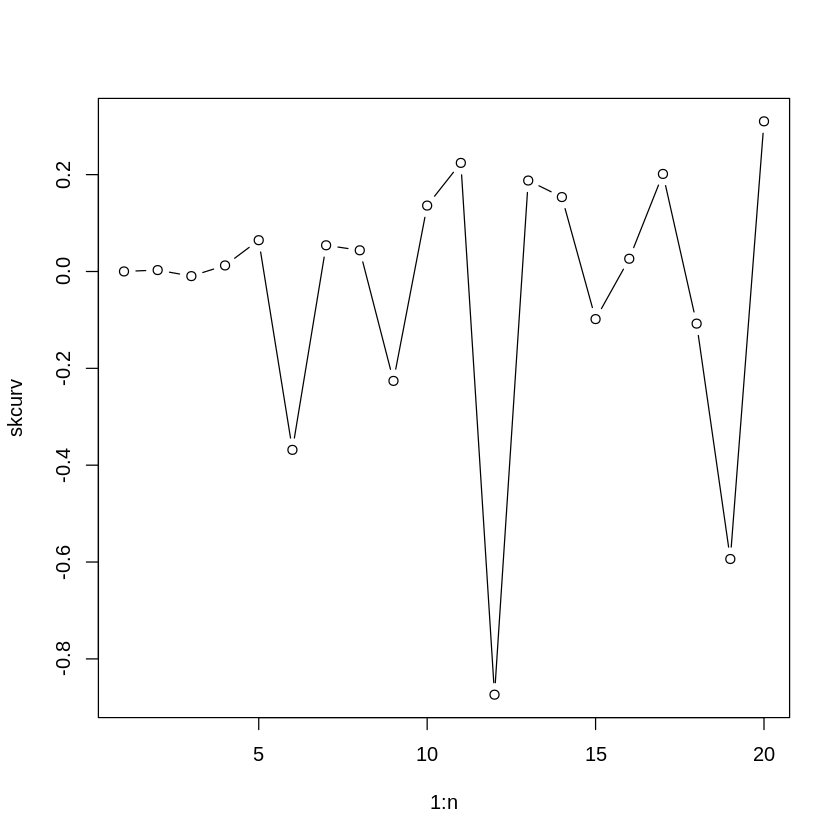

In [ ]:
plot_knee_points <- function(sk, n){
    #' It plots the graph given the singular values.

    fordiff <- function(x) x[2:length(x)] - x[1:(length(x)-1)]
    skd <- fordiff(sk)
    skdd <- fordiff(skd)
    skcurv <- skdd[1:n] / (1+(skd[1:n])^2)^1.5
    plot(1:n, skcurv, type="b")
}

plot_knee_points(lsar$sk, 20)

I test the first local minimum that is 6, so I take the first 6 latent dimensions.

In [ ]:
sim_5_dim <- top(cosines(dls[,1:6], heart_long_ls[1:6]), 10)

# List the 10 songs
songs_df[sim_5_dim, c('title','artist_name', 'tag')]

,title,artist_name,tag
,<chr>,<chr>,<chr>
66791,Moonlight And Roses (Bring Memories Of You),Jim Reeves,jim reeves
144487,If Dreams Come True,Billie Holiday,jazz
19328,Moonlight And Roses,Vic Dana,easy listening
10777,Elements Of Life,Alice DJ,trance
59652,Alone Together,Rufus Wainwright,Broadway
33427,A True True Love (1989 Digital Remaster),Bobby Darin,easy listening
144877,Impress.,The Chariot,hardcore
121549,Feel Me Heaven,Enigma,new age
132213,Alone Together,Carly Simon,oldies


In [ ]:
as.list(songs_df[c(66791, 144487, 59652), 'lyrics'])

[[1]]
[1] "you you you and and and in my of of of love love so heart dream dream light light thought true bring bring bring wonder beauti memori memori memori rose rose rose golden golden moonlight moonlight moonlight sparkl sparkl june june"

[[2]]
[1] "i i the you you and a in in in in is your your that will be love love with come come there see if if eye dream dream dream sky true true smile happi view caress"

[[3]]
[1] "the the the the the the to to and and a not not in is is is are are are are are are we we we we we we we for be love love love what can can there if if as as as as as as night our our world too long were alon alon alon alon rain fear togeth togeth togeth togeth togeth togeth togeth togeth togeth togeth deep sea blind strong abov great great beyond crowd vain proud weather unknown cling"

The results seem better, as you may understand from the lyrics, increasing the information quantity. But this is a qualitative analysis, let's compute the Chi-squared test to confirm if there is a correlation between 'heart long' and 'country' genre within the latent space.

TODO: ripassa R-precision riguardando anche video di Moro magari e guarda anche knee point.

In [ ]:
# We need to fix the maximum number of returned results (R-precision), this number
# is given by the number of 'classic rock' songs within the entire dataset.
# Compute the distribution of the genre in the first k results of the search with k=1..nrow(dls)
# table(genres[top(cosines(dls[, 1:6], heart_long_ls[1:6]), 10)])
#table(genres)
# Give the possibility to retrieve all the 'country' songs that are 4043
#table(genres[top(cosines(dls[, 1:5], rock_like_ls[1:5] ), 2064)])

heart_long_6_dim <- table(1:nrow(dls) %in% top(cosines(dls[,1:6], heart_long_ls[1:6]), 4043), genres=="country" )
dimnames(heart_long_6_dim) <- list('heart long'=c("No", "Yes"), 'country'=c("No", "Yes"))
heart_long_6_dim

          country
heart long     No    Yes
       No  145372   3846
       Yes   3846    197

In [ ]:
chisq.test(heart_long_6_dim, correct=FALSE)


	Pearson's Chi-squared test

data:  heart_long_6_dim
X-squared = 80.736, df = 1, p-value < 2.2e-16


Also considering the latent space, the probability that the query 'heart long' and the genre 'country' are not related is very low. I have a confirmation of this result from a lexical and a semantic point of view.

## Songs recommendation

The next goal is to detect the most similar songs to a given input text in order to build a simple recommendation system based on song lyrics. As first thing I need to load on a dataframe the evaluation dataset that I already downloaded at the beginning of the notebook, it contains for each song a list of similar songs.

In [5]:
evaluation_df <- read.csv(dl_eval$local_path)
# Removing the lyrics to avoid ugly output in the cell
evaluation_df[1:3, names(evaluation_df) != "lyrics"]

,track_id,title,artist_name,tag,target
,<chr>,<chr>,<chr>,<chr>,<chr>
1,TRAAGJV128F1464090,It's My Party,Lesley Gore,60s,"TRDRFLI128F92C94CB,TRQQEEF128F92D5BC4,TRBTMXC128F93462EA,TRTBJAL128F42264D3,TRRVDDS128F426F4B7,TRADZQV128F14A5760,TRFYRVZ128F92EF998,TRTEMVY12903CBE445,TRGWVXK12903CEBA65,TREANGJ128F14989F6,TRMAIRM128F148527E,TRCPSJI12903CD9879,TRHOGMB128F1481949,TRVHVFC128F92F1387,TRMTJVR128F42869A3,TRVXAKZ128F9338E4B,TRQOZWP128F145AD6C,TRSGIEM128F426BD0A,TRRETPJ128F423424B,TRBJLVI128F931DE54,TRZVGBD12903CD74A8,TRLUUPC128F422B8BA,TRJRJKS128F4272C7D,TRAUZVU12903CC050D,TRKSWBS128F426BF3D,TRNONPQ128F424EAD1,TRLYOPY12903CEA123,TRZRJPO128F92EF9C8,TRHYPXT128F9311D29,TRFTAVP128F9311F1A,TRPTUSH128F932EB11,TRONWPP128F42A001A,TRWRMVQ128F421CC11,TRFMIED128F932D8D7,TRFXYRO128F9311F1F,TRIMGYM128E07848C0,TRECXNL128F93227D6,TRXASKT128F92F2D0F,TRLHNLY12903CC0587,TRDGHLY12903CDF60D,TRBRPQK128E07936CD,TRFNVHG128F92D2F81,TRRXMOY12903CB89CE,TRFZWND128F92F84EF,TRZPVUW128E0788A3E,TRYSOIO128F145B04D,TRRAXDO128F9318792,TRTAQMT128EF34FDBD,TRQWKVN128F930F016,TRVRICO128F92CF02F,TRMLSWF128F4252EB7,TRCNLXE12903CC096A,TROQYZD128F92C72BD,TRWSUUY128F14A8CE5,TRBRPIA128F4289506,TRGPUFE128F92CD8C3,TRVQMKL128F4289505,TRHHDYL128F92FC562,TRDZAJJ128F9311EFB,TRRLUML128F145BE12,TRCSJJK128F4287607,TRUENYE128E078FEB5,TRIBBAQ128EF3498C1,TRHMZSP128F145B044,TRSTHYK12903CEB8FA,TRIBLBP128F1485E1C,TRAONAP128F145672D,TRSJDGT128F427B62C,TREEWWU128F932A4F6,TRJHZGS12903CE9854,TRQABRI128F14AD376,TRIUJEC12903CBCD99,TRWNRCJ128F92F2D3C,TRQXNDU128F92E722A,TRASDYZ128F92FB0DF,TRGXQFQ128F427CC14,TRDDLBK128F933D433,TRACXGH128F931686C,TRTPXWT128F92FE179,TRJTTNG128F4269122,TRKANWW128F931EC0D,TRUXBQR128EF349A44,TRVEJTZ12903CA367C,TRJKCEY128F428A578,TRPEEHW128F92F2D0C,TROTYIP128EF365D9D,TRIMALA128F92D2B82,TRUPLRX128F932DE4C,TRAQPUZ128F4299119,TRPYKTG128F42264DE,TRJCUYC128EF34FDBE,TRUMETS128F92CEBF5,TRZJIGI12903CD8859,TRMQOZH128F92D41AC,TRJJRVT12903CD77BD,TRFFQVT128F146519E,TRNTKJE128F92F2E27,TRYBYMN128EF34FE02,TRHCWPI12903CC525B,TRXDHEF12903CB601B,TRIVDKJ12903CBC905,TRCFHUM128F42591BE,TRLBXQC128F1461E67,TROPASI128F148B751,TRLZJNM128F930E168,TRPZXJX12903CD4C72,TRPKZGZ128F4299118,TRTZIUX128F4240C17,TRAATJP12903CBA7D7,TRHTRKM128E0792004,TRKBWVZ128F425F757,TRNBBBH128F92F2D1B,TRFDZYB12903CAB761,TRCSFWV128F933D827,TRWQHZM12903CDDB07,TRCACUG128F92F19D1,TRIPPIC12903CA3689,TRRWFSQ128E0790AC7,TRCLKCO12903CDDB09,TRLQYWK12903CDF8E5,TRKKGJC12903C9FBB5,TROKJBE12903CC9D74,TRVPAQW128F1495910,TRBIUKI128EF349898,TRQVTKP12903CF8AD4,TRHMBSZ128F92D2B67,TRAWOYN128F92F2D34,TRGRGBO128F9349207,TRSWIRD12903CFB6A0,TRIIDLR12903CC6630,TRRJENJ12903CF773F,TRYUQKT128F92F11F5"
2,TRABQCU128F4263E52,In A Big Country,Big Country,80s,"TRPEQOU128E07847ED,TRKVJZZ128F14A312A,TRLYEOK128F423EF9E,TRTQRBC128F148D1D1,TRRZGUM128E0784450,TRHOBGL128E0781A5A,TRJPAYT128F933B284,TRKTHXU12903CD4CC5,TRDTPKS12903CE9127,TRRVFHW12903D07380,TRIIMCE12903CCDACA,TRPZZOD128F4279440,TRZCJZJ128F9364C67,TRYRTCB128F429979B,TRKFQRS128F933A736,TRCZMBU128F42A631B,TRYLMXO128F9319F33,TROTSEC128F93351FA,TRODAWD128F9335B3B,TRSUPZV128F4290CDC,TRIWDDS128F9335B51,TROZWFB128F4288349,TRQJQBY128F4289141,TRJZXRB128F4237618,TRQFMCV128EF35E253,TRCDNFU128F92DF6FB,TRCHYGM128F9312EB0,TRMVKSL128F14640E0,TRSHXKL128F92DE895,TRULMOS128F9300D4F,TRNTHZB128F42873C7,TRJKBCK128F14685A4,TRUTGVT128F92CAB69,TRPWLEH128F9351949,TRKJWCO128F93358E4,TRXRZCB128F92E7F75,TRVVNCW12903CC1532,TRUWUET12903CD89CC,TRJQFKX128F42941F5,TRWLBNO128F14675E4,TRRGVPW128F92F7B65,TRBMXRE128F428F8E7,TRGAUIG128F42795D9,TRAKDIG128E07826B3,TRVPNEE128F4262C1E,TRRIMGL128F145B981,TRDVXFG128F92EC1A7,TRTGSIZ12903CE9121,TRWEKAA12903CB136B,TRDXVMS128F4263EE0,TRYRVNM128F92D2D58,TRNPRJU128F425A0A1,TRANRFB128F1481F1E,TRKPJIG128F42A28CC,TRKIYVD128F428E560,TREUBKI128F42597BE,TRKSJQO128F14592DA,TRGUENC128F9306198,TRIBEPW128F42795D1,TRNCJVN128F933094F,TRUOSPV128F146ADD8,TRNLZLJ128F42599D7,TRCDRYD128F93059D2,TRBBFSS12903D061AF,TRXXSYD128F42973D6,TRVIHNP128F92DF811,TRNPPTP128F428E0A7,TRTOJNN128F4260DD7,TRTOCJU12903CCCD2E,TRH

In [ ]:
min_similar <- min(sapply(sapply(evaluation_df$target, strsplit, split=","), length))
cat("The evaluation dataframe contains", nrow(evaluation_df), "songs with at least", min_similar, "similar ones.")

The evaluation dataframe contains 365 songs with at least 125 similar ones.

I decided to make two simple recommendation system, the first one uses the document matrix of the latent space and I compute the most similar songs considering the cosine similarity. In the second one, I built a doc2vec model and then I computed the most similar songs considering the inner product between the document embeddings.

I need to create a function that compare the track ids of the returned songs with the one of the actual similar ones. 

I import the Metrics package that allows to compute the mean average precision at k and I implemented a simple function that return the mAP@k given the vector of predictions and actual similar songs.

The average precision at k is the sum from P@1 to P@k of the precisions, divided by k. The mean of these values -each query submitted to the system- is the mean average precision.

In [ ]:
install.packages('Metrics', quiet=T)
library('Metrics')

# Import pbapply to show progress while evaluating the dataframe
install.packages("pbapply", quiet=T)
library(pbapply)

opb <- pboptions(char="=", title="Computing mAP on the evaluation dataset", type="timer")

The ***compute_mAP_k*** function is in common between the two methods that I tested on the evaluation dataframe, therefore I declared here.

In [ ]:
compute_mAP_k <- function(k, target, predicted) {
    #' This function return the mAP@k for the 2 given vectors.
    #'
    #' @param predicted It's the vector of predicted track ids.
    #' @param target It's the vector of similar track ids.
    #' @param k Max length of predicted sequence.

    map_res <- mapk(k, target, predicted)
    return(map_res)
}

In the original challenge of the Million Songs Dataset, the models were evaluated considering mAP@500. Unfortunately, I have to use only the songs from the evaluation dataset for which I also have the lyrics, given that my analysis is based on the texts, therefore the maximum mAP that I am able to compute is at 125 for 365 songs.  

### Latent semantic space approach

I implemented some functions to simplify the next steps.     
The first function is used to create the vector in the latent space given a song id. It retrieves the lyrics of that song from the dataframe and it creates a vector on them.

The second one is used to actually retrieve the *n* most similar songs, considering the desired latent dimensions and computing the cosine similarity between the given vector and the documents latent matrix.

In [ ]:
#@title #### Functions to create a latent vector and compute most similar songs
#@markdown If you expand the cell you will find the implementation of the 2 functions

create_lsa_vector <- function(song_id, df, words, tdm) {
    #' It returns the lsa vector of a song, given its name.
    #'
    #' @param song_name The string that represent the unique song id.
    #' @param df The dataframe from which the function retrieves the lyrics.
    #' @param words The list of words used to build the LSA space.
    #' @param tdm The document-term matrix to use for the operation.

    # If a dataframe is passed the function takes the lyrics from that
    if (inherits(df, "data.frame")){
        lyrics <- df[df$track_id == song_id, "lyrics"]
    }
    else{
        lyrics <- df
    }
    lyrics_vec <- query(lyrics, words)
    lyrics_le <- lw_logtf(lyrics_vec) * (1-entropy(tdm))
    lyrics_ls <- t(lyrics_le) %*% lsar$tk
    return(lyrics_ls)
}


compute_most_similar_songs <- function(dls, l_dim, df, song_vec, n) {
    #' It returns the dataframe with the most similar songs to the one given as
    #' input.
    #'
    #' @param dls The document-term matrix of the latent space.
    #' @param l_dim The latent dimensions to use for computing the cosine similarity. Passed as a list.
    #' @param df The dataframe from which the function will retrieve the information about the similar songs.
    #' @param song_vec The latent vector that represents the song for which we want similar ones.
    #' @param n The number of similar songs the function has to retrieve.

    sim_song_idx <- top(cosines(dls[, l_dim], song_vec[l_dim]), n)
    return(df[sim_song_idx, names(df) != 'lyrics'])
}

In [ ]:
#@title #### Functions to compute the mAP@k for the evaluation dataframe using LSI
#@markdown If you expand the cell you will find the implementation of the functions.
predict_row <- function(eval_data, songs_df, l_dim, k) {
    #' It creates the vector for the song, compute the most similar ones and returns them as string.
    #' 
    #' @param eval_data It's the list of data taken from one row of the evaluation dataframe.
    #' @param songs_df The dataframe of songs that the function gives as input to
    #'        'create_lsa_vector'.
    #' @param l_dim The latent dimensions to consider for the cosine similarity.
    track_id <- eval_data['track_id']

    song_vec <- create_lsa_vector(track_id, eval_data['lyrics'], words, tdm)
    predicted <- compute_most_similar_songs(dls, l_dim, songs_df, song_vec, k)
    return(paste(predicted$track_id, collapse=","))
}


evaluate_dataset <- function(eval_df, songs_df, k, l_dim) {
    #' It makes the prediction for each element of the evaluation dataframe and it
    #' saves the results in the 'predictions' column, then it computes the mAP.

    eval_df['predictions'] <- pbapply(eval_df, 1, predict_row, songs_df=songs_df, l_dim=l_dim, k=k)
    # Transform each string in a list to compute the mAP
    predictions <- sapply(eval_df$predictions, strsplit, split=",", USE.NAMES=F)
    targets <- sapply(eval_df$target, strsplit, split=",", USE.NAMES=F)

    return(compute_mAP_k(k, targets, predictions))
}

I start computing the mAP@125 considering the third and fourth latent dimensions for the cosine similarity function.

In [ ]:
map_4 <- evaluate_dataset(evaluation_df, songs_df, 125, 3:4)
cat("The mAP@125 for the songs is: ", map_4)

  |==================================================| 100% elapsed=21m 36s
The mAP@100 for the songs is:  7.749734e-05

Now I use the knee points, that you can see in the graph below, in order to test the best number of dimensions to keep for improving the mAP.

The first interval is from the first dimension to the sixth.

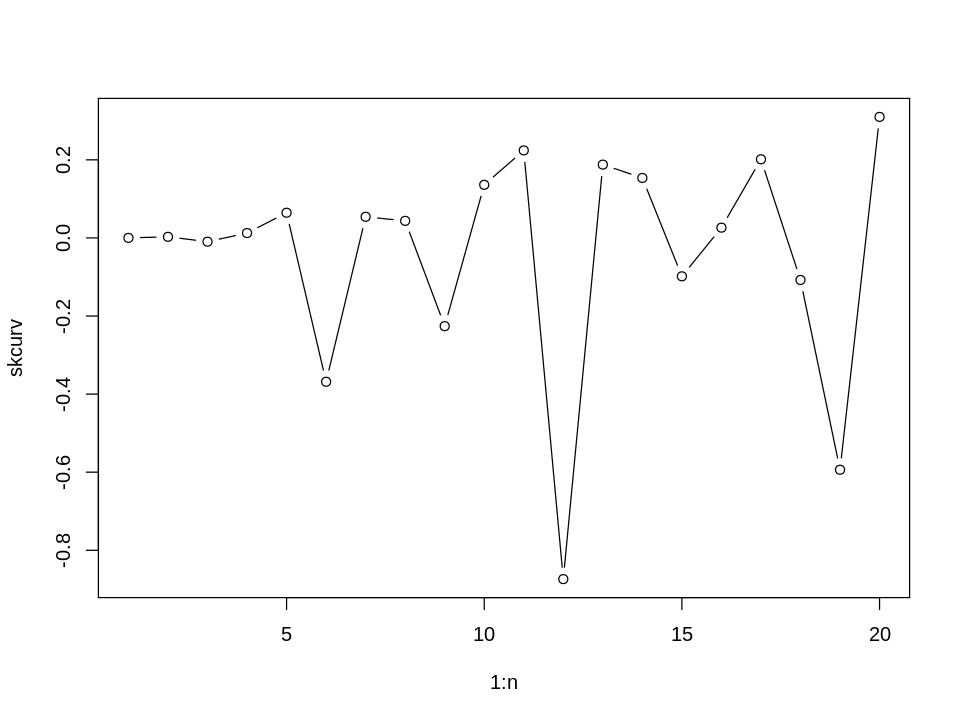

In [ ]:
options(repr.plot.width=8, repr.plot.height=6)
plot_knee_points(lsar$sk, 20)

In [ ]:
map_6 <- evaluate_dataset(evaluation_df, songs_df, 125, 1:6)
cat("The mAP@125 for the songs is: ", map_6)

  |==================================================| 100% elapsed=21m 49s
The mAP@125 for the songs is:  7.121029e-05

The second one is considering up to the ninth dimension.

In [ ]:
map_9 <- evaluate_dataset(evaluation_df, songs_df, 125, 1:9)
cat("The mAP@125 for the songs is: ", map_9)

  |==================================================| 100% elapsed=21m 54s
The mAP@125 for the songs is:  0.0001114848

The score is growing therefore I continue considering more dimensions.

In [ ]:
map_12 <- evaluate_dataset(evaluation_df, songs_df, 125, 1:12)
cat("The mAP@125 for the songs is: ", map_12)

  |==================================================| 100% elapsed=22m 14s
The mAP@125 for the songs is:  0.00015975

In [ ]:
map_15 <- evaluate_dataset(evaluation_df, songs_df, 125, 1:15)
cat("The mAP@125 for the songs is: ", map_15)

  |==================================================| 100% elapsed=20m 27s
The mAP@125 for the songs is:  0.0001422076

In [ ]:
map_19 <- evaluate_dataset(evaluation_df, songs_df, 125, 1:19)
cat("The mAP@125 for the songs is: ", map_19)

  |==================================================| 100% elapsed=20m 36s
The mAP@125 for the songs is:  0.0001425188

The best result is obtained considering up to the twelfth eigenvalue, after that the results stop to improve. It seems reasonable since the most important information about the data is in the first dimensions.

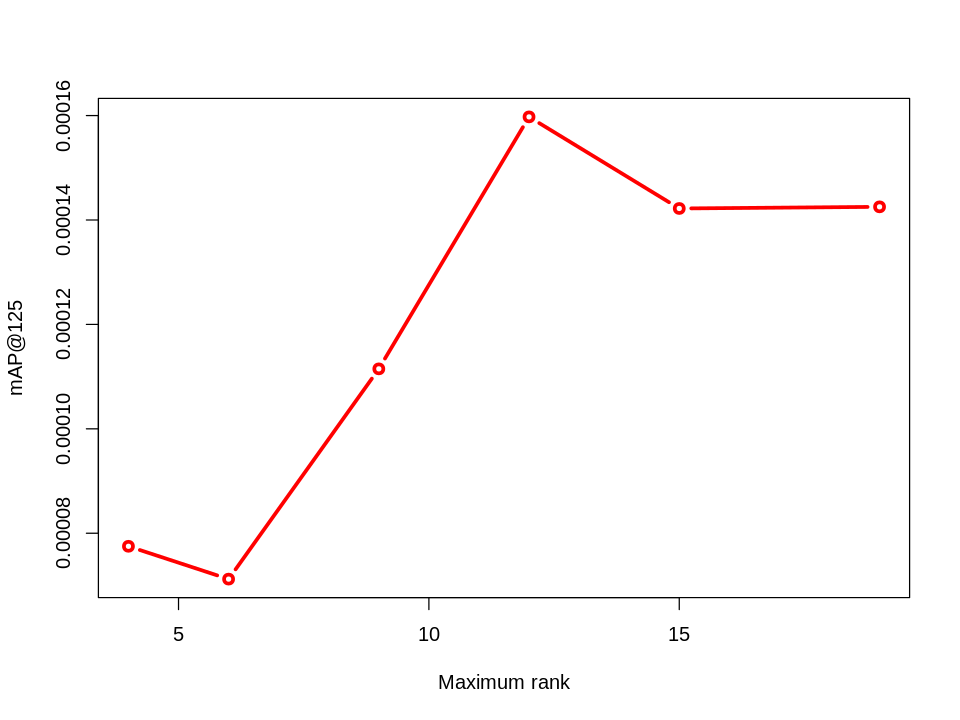

In [18]:
map_index <- c(4, 6, 9, 12, 15, 19)
map_results <- c(map_4, map_6, map_9, map_12, map_15, map_19)

options(repr.plot.width=8, repr.plot.height=6)
plot(map_index, map_results, type="b", col="red", lwd=3, xlab="Maximum rank", ylab="mAP@125")

The obtained mAP scores are very low, this means that the suggestions are not accurate. There could be different reasons:
- it's difficult to suggest a song based on the lyrics alone, different genres can have similar texts but other completely different features (tempo, melody, ...).
- The representative words for a genre / songs are few with respect to the entire dictionary of considered words.
- The songs are a lot and not very divided in clusters, as said before, therefore there are many possible suggestions and similar to each other.

### Doc2Vec method

In order to compare the previous system with others, I also tried the ***Doc2Vec*** algorithm, that creates an embedding for each document and then I compute the most similar to a given one.

I used the method called Paragraph Vector with a Distributed Bag Of Words (PVDBOF), it is based on the Word2vec skip-gram model, with one exception,instead of using the target word as the input, it takes the document ID as the input and tries to predict randomly sampled words from the document.

In [ ]:
install.packages("doc2vec", quiet=T)
library("doc2vec")

In the given package, there is a limit of maximum 1000 words for each document (song lyrics) and therefore I removed all the songs with more than 1000 words. Furthermore, I kept only the 'track_id' and 'lyrics' columns and I renamed them to 'doc_id' and 'text' as requested by the library.

In [ ]:
# Remove songs with more than 1000 words and keep the right columns
corpus_doc2vec <- songs_df[(sapply(sapply(songs_df$lyrics, strsplit, split=" "), length) <= 1000), c('track_id', 'lyrics')]
names(corpus_doc2vec) <- c('doc_id', 'text')

In [ ]:
cat("The removed songs are", nrow(songs_df) - nrow(corpus_doc2vec))

The first time that I execute it I needed to compute the model, then I pre-saved it and you can simply execute the following cell to download it from Drive and load it in the variable. I decided to use 100 dimensions for the document embeddings.

In [ ]:
#@title #### Load the pre-saved doc2vec model from Drive
# Download from Drive
url_doc2vec <- "https://drive.google.com/file/d/150VWDsTBFsMalxv1bXPsDbANAGKNztnr/view?usp=share_link"

drive_deauth()
dl_doc2vec <- drive_download(as_id(url_doc2vec), overwrite=TRUE)

# Read the model
doc2vec_model <- read.paragraph2vec(dl_doc2vec$local_path)
str(doc2vec_model)

In [ ]:
#@title #### Compute the doc2vec model on the corpus (~40 minutes)
# Compute the doc2vec from the corpus 
doc2vec_model <- paragraph2vec(corpus_doc2vec, dim=100, threads=2)

write.paragraph2vec(doc2vec_model, "doc2vec_model.bin")

doc2vec_model

In [ ]:
# Retrieve document embeddings as matrix
emb_docs <- as.matrix(doc2vec_model, type="docs")

I wrote a couple of functions in order to compute the mAP@125 considering the doc2vec model.

In [ ]:
#@title #### Functions to compute the mAP@k for the evaluation dataframe considering doc2vec

compute_similars_doc2vec <- function(doc2vec_model, emb_docs, lyrics_list, k=125) {
    #' It returns the list of most similar song ids.
    #'
    #' @param doc2vec_model The doc2vec model trained on songs_df.
    #' @param emb_docs The matrix of the document embeddings.
    #' @param lyrics_list The lyrics of a song as a list of words.
    #' @param k The number used to compute the mAP.

    embedding <- predict(doc2vec_model, lyrics_list, type="embedding")
    # Compute the most similar documents considering the doc2vec embedding
    predictions <- paragraph2vec_similarity(embedding, emb_docs, top_n=k)['term2']
    #predict(doc2vec_model, newdata=lyrics_list, type="nearest", which="sent2doc", top_n=k)
    return(unname(as.list(predictions))[[1]])
}


predict_row_doc2vec <- function(eval_data, doc2vec_model, emb_docs, k) {
    #' It creates the vector for the song, compute the most similar ones and returns them as string.
    #' 
    #' @param eval_data It's one row of the evaluation dataframe.
    #' @param doc2vec_model It's the doc2vec model created on the songs dataset.
    #' @param emb_docs The matrix of the document embeddings.
    #' @param k The number of predictions to compute.

    lyrics_list <- list(pred=strsplit(eval_data['lyrics'], split=" ")[[1]])
    predicted <- compute_similars_doc2vec(doc2vec_model, emb_docs, lyrics_list, k)
    return(paste(predicted, collapse=","))
}


evaluate_dataset_doc2vec <- function(eval_df, doc2vec_model, emb_docs, k) {
    #' It computes the mAP@k on the passed evaluation dataframe
    #'
    #' @param eval_df The evaluation dataframe to consider for computing the mAP.
    #' @param doc2vec_model The doc2vec model to use for the operations.
    #' @param emb_docs The matrix of the document embeddings.
    #' @param k The number to consider to compute the mAP

    eval_df['predictions'] <- pbapply(eval_df, 1, predict_row_doc2vec, doc2vec_model=doc2vec_model, emb_docs=emb_docs, k=k)
    # Transform each string in a list to compute the mAP
    predictions <- sapply(eval_df$predictions, strsplit, split=",", USE.NAMES=F)
    targets <- sapply(eval_df$target, strsplit, split=",", USE.NAMES=F)

    return(compute_mAP_k(k, targets, predictions))
}

In order to avoid errors, I also have to remove the songs with more than 1000 words from the evaluation dataframe.

In [ ]:
# Otherwise crash of the RAM
evaluation_df <- evaluation_df[(sapply(sapply(evaluation_df$lyrics, strsplit, split=" "), length) <= 1000), ]
cat("The evaluation dataframe has now", nrow(evaluation_df), "songs.")

In [ ]:
cat("The mAP@125 considering the doc2vec model is", evaluate_dataset_doc2vec(evaluation_df, doc2vec_model, emb_docs, 125))

  |==================================================| 100% elapsed=45s  
The mAP@125 considering the doc2vec model is 0.0001116594

As you can notice, the resulting score is a bit worse than the best obtained using LSI, therefore I can conclude that this type of approaches, considering only the song lyrics, don't work very well for a recommendation system.